# Import

In [133]:
from ABCD import *
from tests import *

import matplotlib.pyplot as plt


GHz = 1e9
MHz = 1e6
kHz = 1e3
fF = 1e-15
um = 1e-6
us = 1e-6
ms = 1e-3
nH = 1e-9

pi = np.pi
vp = 1.2e8
z0 = 50

w_scale = 2*pi*MHz

In [134]:
plt.rcParams.update({
    'font.size'        : 12, 
    'figure.facecolor' : '1',
    'figure.dpi'       : 300,
    'figure.figsize'   : (5, 4),
})

# Installations

To run this notebook create a new python environment:

```bash
conda create -n abcd_workshop python=3.13
conda activate abcd_workshop
```

Then cd into this folder and run

```bash
pip install -r requirements.txt
```

# Exercise 1: Implement ABCD matrices

In this exercise we implement the ABCD matrices for various circuit elements. We will also concatenate them to describe larger networks.

## 1a: Implement ABCD matrices

Below we give an example of the ABCD matrix for series inductance. Note that we define a 2x2 matrix for each frequency of a frequency array. Follow the structure of this function to fill out the function in later sections.

In [3]:
#-- Example matrx ------------------------------------------------------------

def get_ABCD_series_inductance(
        w_array: np.ndarray, # array of frequencies, shape (N,)
        ind: float # inductance
        ) -> np.ndarray: # array of ABCD matrices, one per frequency, shape (2,2,N)
    
    """
    ABCD matrix for a series inductor.
    The ABCD matrix for a series inductor is given by:
    | A  B | = | 1  jωL |
    | C  D | = | 0  1   |

    Parameters
    ----------
    w_array : np.ndarray
        Array of angular frequencies (rad/s).
    ind : float
        Inductance value (H).

    Returns
    -------
    np.ndarray
        Array of ABCD matrices for the series inductor, one at each frequency, shape (N, 2, 2).
    """

    # abcd_arr needed in shape of w_array
    abcd_arr = np.zeros((len(w_array), 2, 2), dtype=np.complex128)

    for i in range(len(abcd_arr)):
        abcd_arr[i] = np.array([
            [1    ,       1j*w_array[i]*ind],   
            [0   ,                        1]
        ])

    return abcd_arr

In [ ]:
#-- Run tests -----------------------------------------------------------------
freq
test_series_inductance(get_ABCD_series_inductance)

ABCD_series_inductance CORRECT.


In [11]:
#-- Fill in the blanks! ------------------------------------------------------------

def get_ABCD_series_capacitance(
        w_array: np.ndarray, # array of frequencies, shape (N,)
        c: float # capacitance
        ) -> np.ndarray: # array of ABCD matrices, one per frequency, shape (N,2,2)

    abcd_arr = np.zeros((len(w_array), 2, 2), dtype=np.complex128)

    #-- TODO: Fill in ABCD matrix ----------------------------------------------------
    for i in range(len(abcd_arr)):
        abcd_arr[i] = np.array([
            [1    ,      1 / (1j*w_array[i]*c)],   
            [0   ,                           1]
        ])
    #---------------------------------------------------------------------------------

    return abcd_arr


def get_ABCD_transmission_line(
        w_array: np.ndarray, # array of frequencies, shape (N,)
        l: float, # length of transmission line
        z0: float, # characteristic impedance
        vp: float # phase velocity
        ) -> np.ndarray: # array of 2x2 ABCD matrices, one per frequency, shape (N,2,2)

    abcd_arr = np.zeros((len(w_array), 2, 2), dtype=np.complex128)

    #-- TODO: Fill in ABCD matrix ----------------------------------------------------
    for i in range(len(abcd_arr)):
        bl = l*(w_array[i]/vp)
        abcd_arr[i] = np.array([
            [np.cos(bl), 1j*z0*np.sin(bl)],
            [1j*(1/z0)*np.sin(bl), np.cos(bl)]
        ])

    #---------------------------------------------------------------------------------

    return abcd_arr


def get_ABCD_parallel_inductance(
        w_array: np.ndarray, # array of frequencies, shape (N,)
        ind: float # inductance
        ) -> np.ndarray: # array of ABCD matrices, one per frequency, shape (N,2,2)

    abcd_arr = np.zeros((len(w_array), 2, 2), dtype=np.complex128)

    #-- TODO: Fill in ABCD matrix ----------------------------------------------------
    for i in range(len(abcd_arr)):
        abcd_arr[i] = np.array([
            [1    ,                         0],   
            [1 / (1j*w_array[i]*ind)   ,    1]
        ])
    #---------------------------------------------------------------------------------

    return abcd_arr


Check your implementation.

In [12]:
test_series_capacitance(get_ABCD_series_capacitance)
test_transmission_line(get_ABCD_transmission_line)
test_parallel_inductance(get_ABCD_parallel_inductance)


ABCD_series_capacitance CORRECT.
ABCD_transmission_line CORRECT.
ABCD_parallel_inductance CORRECT.


## 1b: Implement S21 parameter

Complete the code to convert a abcd matrices into an s21 parameter.

In [15]:
def s21_from_abcd(
        abcd_arr: np.ndarray, # array of 2x2 ABCD matrices, one per frequency, shape (N,2,2)
        z0: float # characteristic impedance
        ) -> np.ndarray: # array of scalar s21 values, one per frequency, shape (N,)

    #-- TODO: Write s21 function -----------------------------------------------------
    a = abcd_arr[:, 0, 0] # Upper left matrix element for each frequency
    b = abcd_arr[:, 0, 1]
    c = abcd_arr[:, 1, 0]
    d = abcd_arr[:, 1, 1]
    s21_arr = 2/ (a + b / z0 + c * z0 + d)
    #---------------------------------------------------------------------------------


    return s21_arr

Check your implementation.

In [16]:
test_s21(s21_from_abcd)

s21_from_abcd CORRECT.


## 1c: Implement simple matrix multiplication

In this exercise, we multiply abcd matrices together to find the total abcd matrix of a concatenated networks. 

In our code, an abcd matrix is given as an array of shape ```(N,2,2)```, one 2x2 matrix per frequency. Therefore, to multiply two abcd matrix arrays together, we need to multiply them frequency-wise. The function ```multiply_abcd_matrices``` takes a list of abcd matrices and returns the frequency-wise product of the abcd arrays in the list.


In [32]:
#-- Define function to multiply matrices ------------------------------------------------

def multiply_abcd_matrices(
        abcd_list : list, # list of ABCD matrices (each shape 2x2xN)
        ):
    
    for i, abcd_arr in enumerate(abcd_list):
        assert len(abcd_arr.shape) == 3 and abcd_arr.shape[1:]==(2,2), f'abcd_list[{i}] must have shape (n, 2, 2)'
    # Initialize the result as the first array
    result = abcd_list[0]
    # Compute the dot product sequentially with each subsequent array
    for abcd_arr in abcd_list[1:]:
        result = np.einsum('nij,njk->nik', result, abcd_arr)
    return result

Use the function to compute the ABCD matrix of the circuit depicted below.

<img src="images/abcd_1c_circuit.png" alt="ABCD Circuit" width="300">


In [33]:
#-- Circuit parameter definitions ------------------------------------------------

C = 30*fF       # capacitance
ind = 1*nH      # inductance
l = 4000*um     # length of transmission line

w_arr_1c = 2*pi* np.linspace(2, 60, 20_000) * GHz # frequency array in rad/s

In [34]:
#-- TODO: implement the abcd matrix multiplication for the cirucits above -----------------------------------------------------------------------
abcd_series_cap = get_ABCD_series_capacitance(w_arr_1c, C)
abcd_tline = get_ABCD_transmission_line(w_arr_1c, l, z0, vp)
abcd_parallel_ind = get_ABCD_parallel_inductance(w_arr_1c, ind)


abcd_total_1c = multiply_abcd_matrices([abcd_series_cap, abcd_tline, abcd_parallel_ind]) 


Check your implementation.

In [35]:
test_abcd_total_1c(abcd_total_1c)

abcd_total_1c CORRECT.


Plot the S21 spectrum.

We provide a function for easy plotting. We pass the frequency array, and then an arbitrarily long list of tuples. Each tuple contains ```(S21_array, label, linestyle)```. One can also pass lists of values that are plotted as vertical lines. 


In [36]:
def plot_s21(
    w_arr: np.ndarray, # array of frequencies in rad/s, shape (N,)
    s21_tuple: list[Tuple[np.ndarray, str, str]], # tuple of s21 trace, label, and linestyle

    vline_list_1: List[float]=[], # list of values to plot as vlines, shape (M,1)
    v_line_list_2: List[float]=[], # list of values to plot as vlines, shape (M,1)
    label_1: str='', # label for the first vlines
    label_2: str='', # label for the second vlines

    ) -> None: # None
    
    #-- Calculate S21 in dB and plot -----------------------------------------------
    w_arr_ghz = w_arr / (2 * np.pi * GHz) # convert the x-axis to GHz

    for s21, label, linestyle in s21_tuple:
        plt.plot(
            w_arr_ghz,
            s21,
            linestyle=linestyle,
            label=label
        )
    

    #-- Add vertical lines if available --------------------------------
    for val in vline_list_1:
        plt.axvline(x=val, color='C1', linestyle='--')

    for val in v_line_list_2:
        plt.axvline(x=val, color='C2', linestyle='--')

    if label_1:
        plt.plot([], [], '--', color='C1', label=label_1)
    if label_2:
        plt.plot([], [], '--', color='C2', label=label_2)
    

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xlabel('Frequency (GHz)')
    plt.ylabel('S21')
    plt.show()

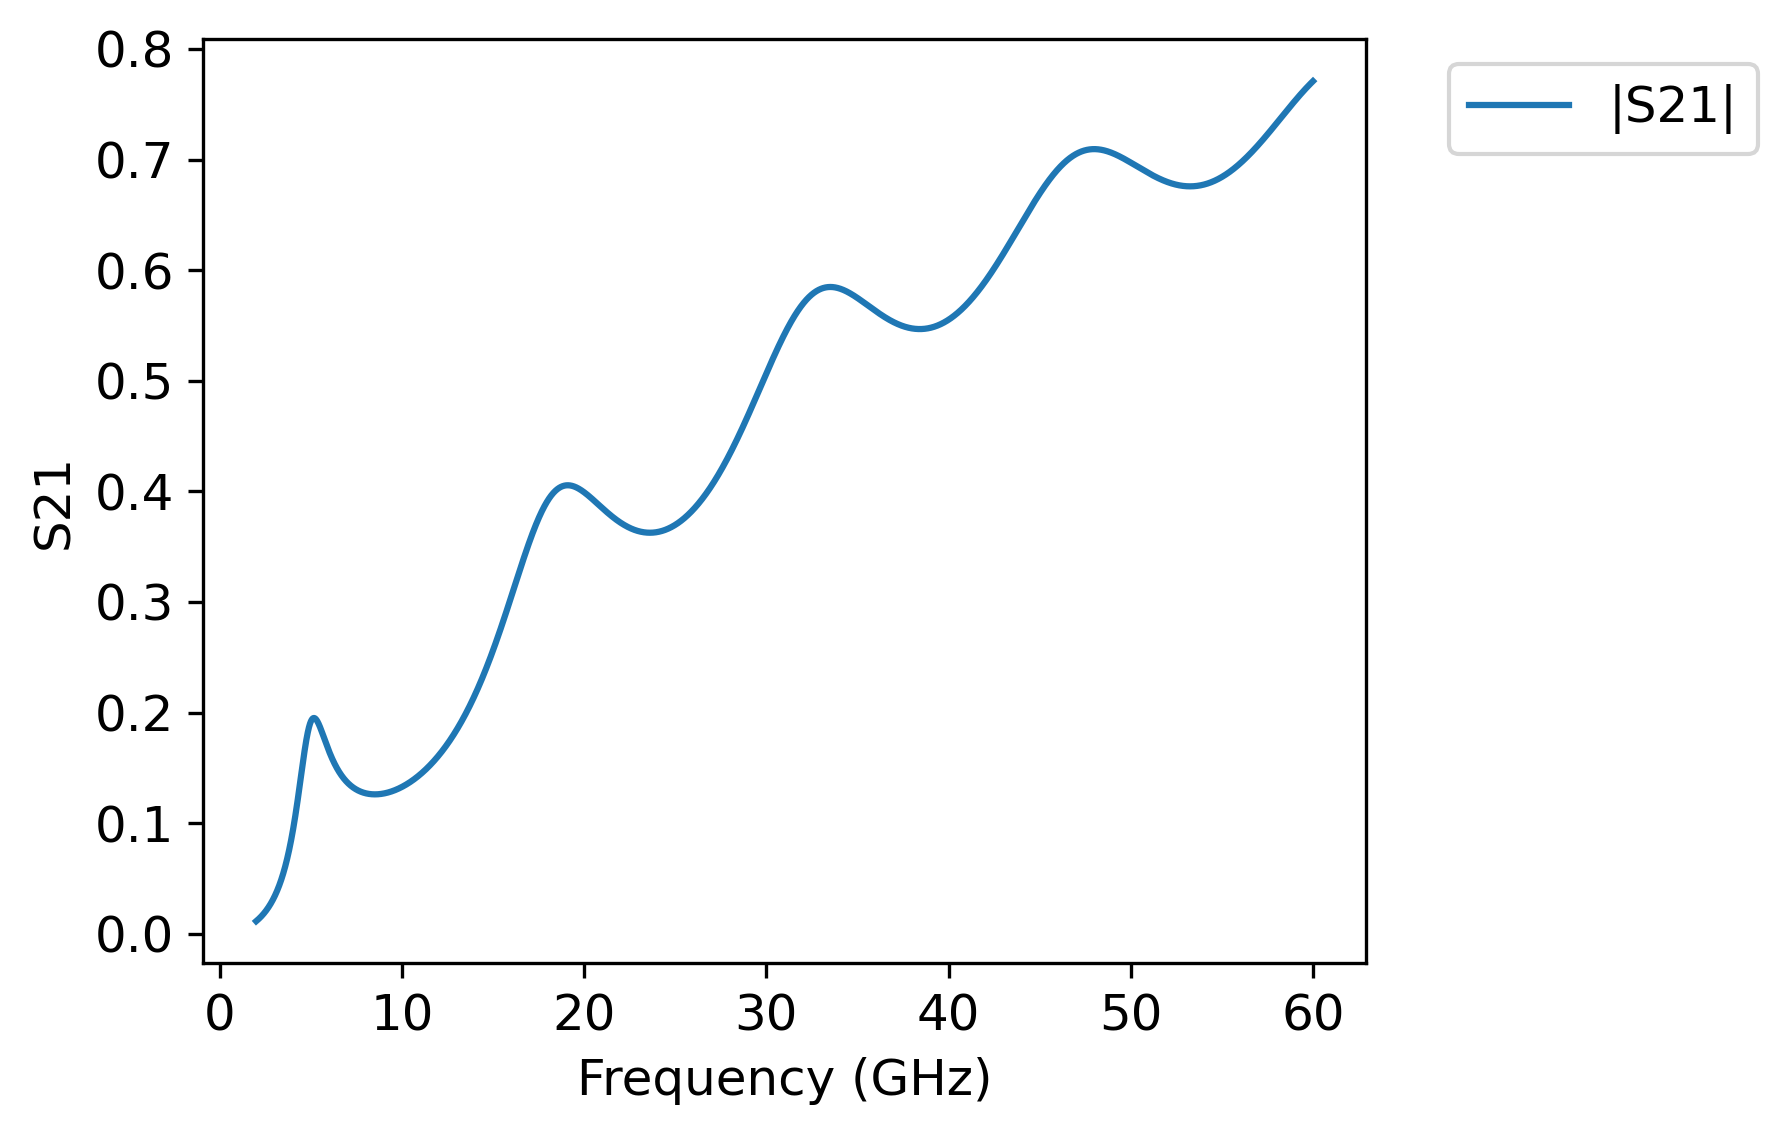

In [37]:

s21_1c = s21_from_abcd(abcd_total_1c, z0)

plot_s21(
    w_arr_1c, 
    [(np.abs(s21_1c), '|S21|', '-')]
    )


## 1d: Transform ABCD network to hanger circuit (T-Junction)

Implement the ABCD matrix that transforms a circuit into a hanger circuit, which we also refer to as T-junction. Below we give the corresponding circuit for our example from 1c.

<img src="images/abcd_1d_circuit.png" alt="ABCD Circuit" width="300">


In [42]:
def get_ABCD_T_junction(
        abcd_arr: np.ndarray, # array of 2x2 ABCD matrices, one per frequency, shape (N,2,2)
    )-> np.ndarray: # array of 2x2 ABCD matrices, one per frequency, shape (N,2,2)

    abcd_T_junction_arr = np.zeros((len(abcd_arr), 2, 2), dtype=np.complex128)

    #-- TODO: Fill in ABCD matrix ----------------------------------------------------
    for i in range(len(abcd_arr)):
        abcd_T_junction_arr[i] = np.array([
        [1    ,                                      0],   
        [abcd_arr[i, 1, 1] /  abcd_arr[i, 0, 1] ,    1]
    ])
    
    #---------------------------------------------------------------------------------

    return abcd_T_junction_arr

In [43]:
#-- Apply T-junction to the circuit --------------------------------------------
abcd_1d = get_ABCD_T_junction(abcd_total_1c)

Check your implementation.

In [44]:
test_abcd_1d(abcd_1d)

get_ABCD_T_junction CORRECT.


Plot the S21 spectrum.

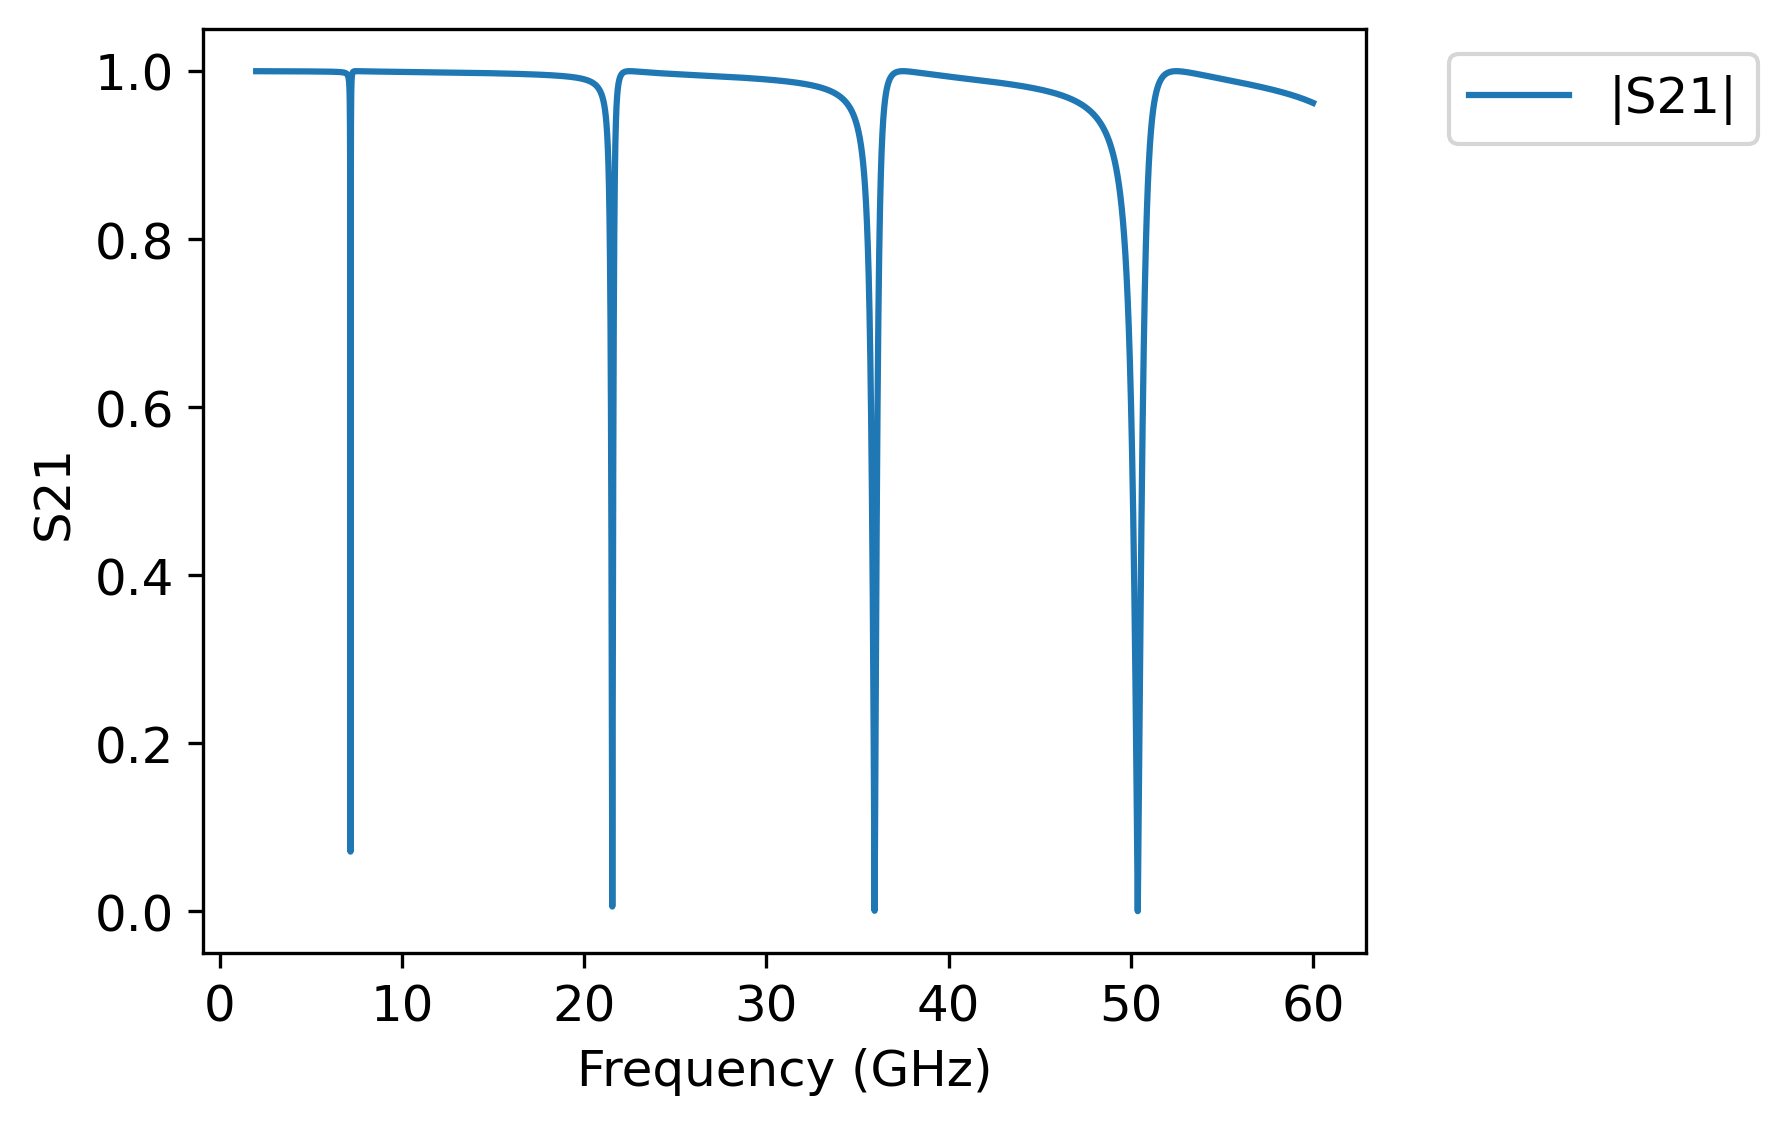

In [45]:
w_arr_1d = 2*pi* np.linspace(2, 60, 20_000) * GHz # frequency array in rad/s
s21_1d = s21_from_abcd(abcd_1d, z0)

plot_s21(
    w_arr_1d, 
    [(np.abs(s21_1d), '|S21|', '-')]
    )

# Intermission I: Use the provided ABCD class (draws circuits)

You have now learned how to implement basic ABCD matrix multiplication. In this notebook, we are also providing a class that implements the same, but also automatically draws the network you are building. This can be helpful for debugging.

As opposed to the previous implementation, we only require a frequency array when computing the S-parameters. The ABCD matrices are only instantiated with their circuit parameters. 

Matrix multiplication is done simply by multipying the ABCD objects together.

See below for examples.

In [46]:
series_cap = ABCDSeriesCapacitance(1)
parallel_cap = ABCDParallelCapacitance(1)
series_ind = ABCDSeriesInductance(1)
parallel_ind = ABCDParallelInductance(1)
tline = ABCDTEMTransmissionLine(1, z0, vp)

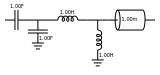

In [47]:
abcd_example_1 = (series_cap
                * parallel_cap
                * series_ind
                * parallel_ind
                * tline)
abcd_example_1

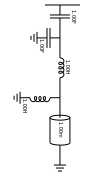

In [48]:
abcd_example_2 = ABCDTJunction(abcd_example_1)
abcd_example_2

If the circuits get crowded, you can also use ```ABCDInverse()``` to flip the circuit, visually. This doesn't change the ABCD matrix.


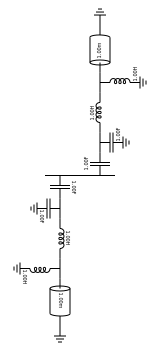

In [51]:
abcd_example_2 * ABCDInverse(abcd_example_2)

Feel free to draw different circuit topologies. 

In [ ]:
#-- TODO: construct different circuit topologies -----------------------------------------------------------------------






Now, we build the same circuit from 1d, and show how to compute the S-parameters. To do this, we first construct our ABCD matrix. Then, we call 

```python
abcd.sparams(w_arr, z0)
```

This returns a list of S-parameters in the form:

S = [S11, S12, S21, S22]

So, to extract S21, we can simply do:

```python
s21 = abcd.sparams(w_arr, z0)[2]
```




In [52]:
#-- Circuit parameter definitions ------------------------------------------------
C = 30*fF       # capacitance
ind = 1*nH      # inductance
l = 4000*um     # length of transmission line

w_arr_int = 2*pi* np.linspace(2, 60, 20_000) * GHz # frequency array in rad/s

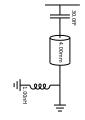

In [53]:
abcd_example_3 = ABCDTJunction(ABCDSeriesCapacitance(C)
                               * ABCDTEMTransmissionLine(l, z0, vp)
                               * ABCDParallelInductance(ind))
abcd_example_3

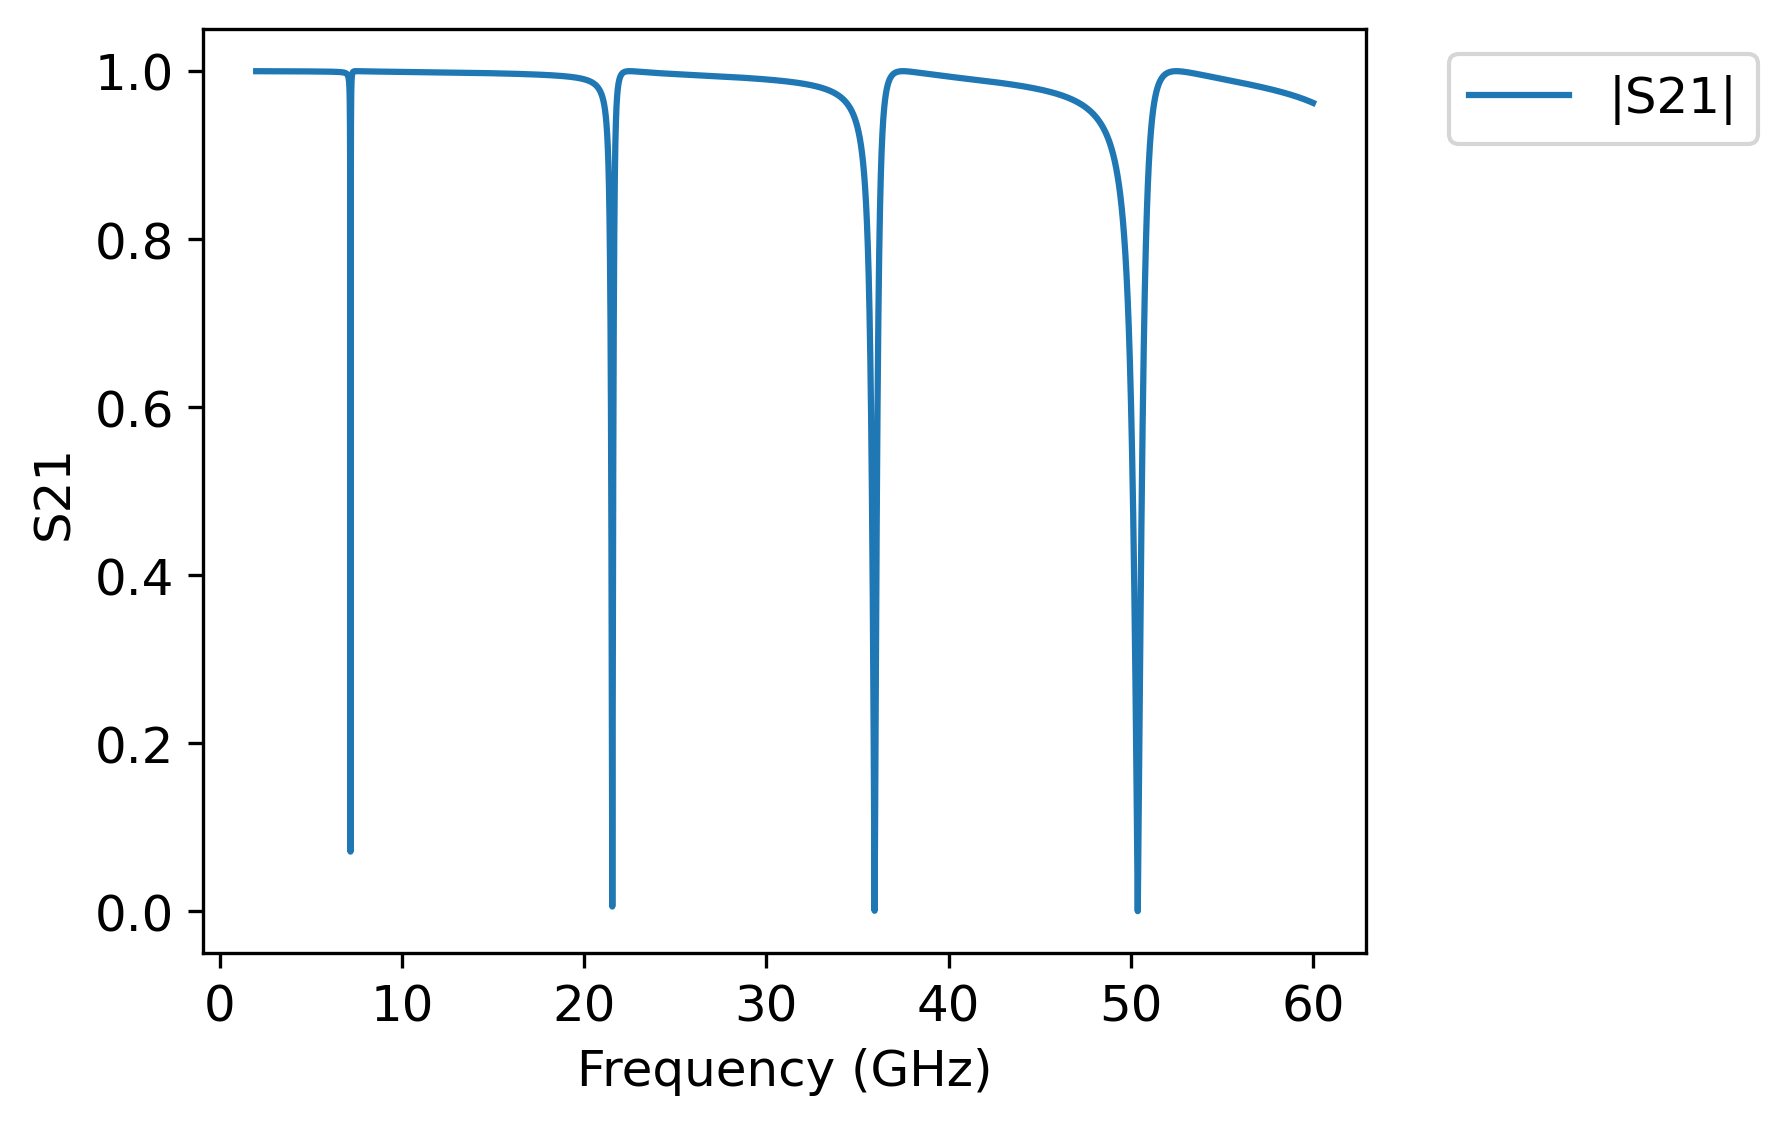

In [54]:
s21_example_3 = abcd_example_3.sparams(w_arr_int, z0)[2]

plot_s21(
    w_arr_int, 
    [(np.abs(s21_example_3), '|S21|', '-')]
    ) 

Finally, note that the inductance from our exmaple does not actually affect the circuit behavior, since it is shorted out. The resulting circuit ends up being a simple hanger quarter-wave resonator, as shown below.

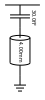

In [57]:
abcd_example_4 = ABCDTJunction(
                    ABCDSeriesCapacitance(C) 
                    * ABCDTEMTransmissionLine(l, z0, vp))
abcd_example_4

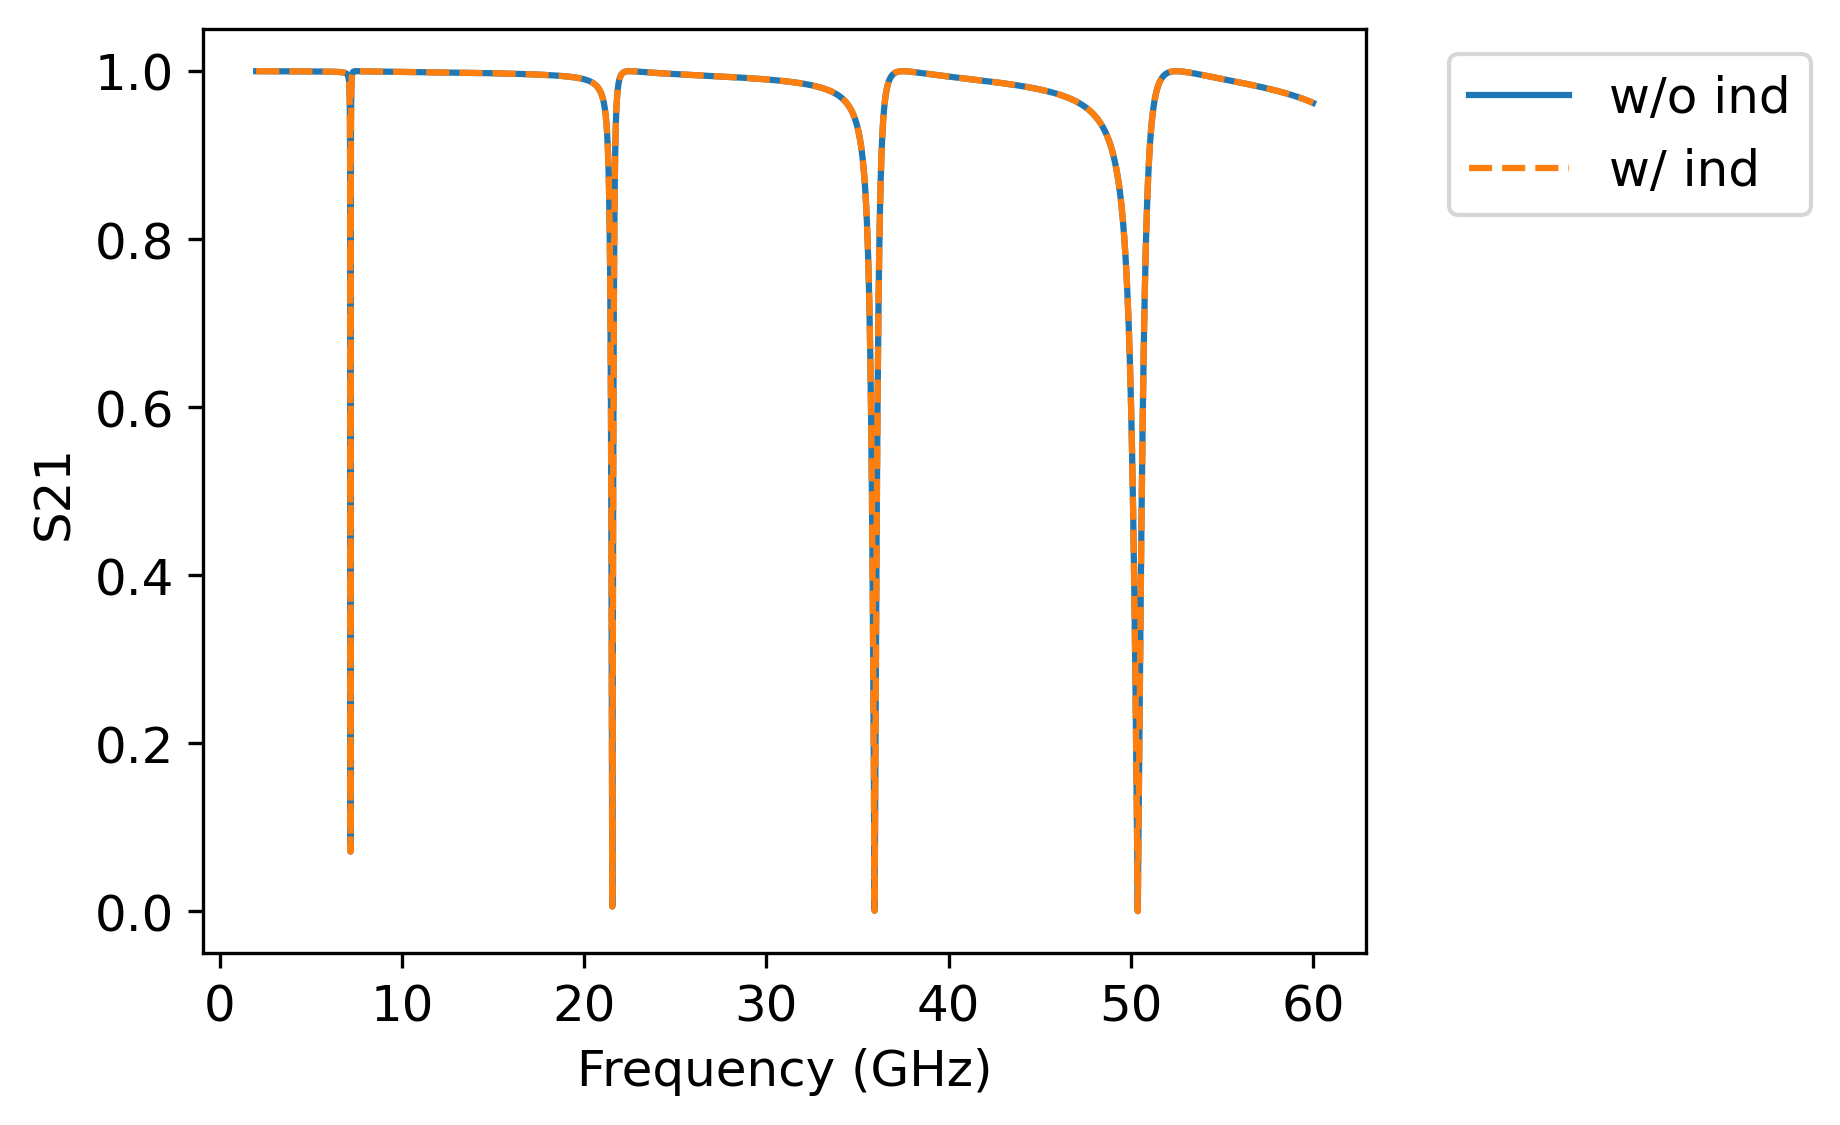

In [56]:
s21_example_4 = abcd_example_4.sparams(w_arr_int, z0)[2]

plot_s21(
    w_arr_int,
    [(np.abs(s21_example_4), 'w/o ind', '-'),
    (np.abs(s21_example_3), 'w/ ind', '--')]
)


# Exercise 2: Resonators

In this exercise we investigate our quarter-wave resonator further. We begin by studying its resonance frequencies. Then we construct lumped LC and half-wave resonators. Later, we extract the linewidth of the quarter-wave resonator using non-linear fitting.

We show the circuit quarter-wave resonator once more.

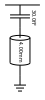

In [58]:
abcd_example_4

## 2a: Calculate resonance frequencies for the quarter-wave resonator

Now, complete the function for the resonance frequencies of a quarter-wave resonatar. Include the capacitive correction. Find the formula in the slides.

In [65]:
def get_f_n_quarter_wave(
        n, # index of the harmonic
        C_c, # coupling capacitance
        l, # length of quarter wave reosnator
        z0, # characteristic impedance
        vp # phase velocity
    ) -> float: # frequency of the nth harmonic in Hz.
    
    #-- TODO: ----------------------------------------------------
    l_eff = l + vp * z0 * C_c
    f_n = vp / (4 * l_eff) * (2*n - 1)
    #---------------------------------------------------------------------------------


    return f_n

Check your implementation.

In [66]:
test_get_f_n_2a(get_f_n_quarter_wave)

get_f_n_quarter_wave CORRECT.


Next, calculate the first four resonances of the above quarter-wave resonator, with and without the capacitive correction. 

Pay attention to units! Your function returns the frequencies in Hz. Please provide the list of freqeuncies in GHz. Your solutions will be marked as incorrect otherwise.

In [78]:
#-- TODO: calculate the first four resonances in GHz -----------------------------------------------------------------------
C_c = 30*fF       # capacitance
ind = 1*nH      # inductance
l = 4000*um     # length of transmission line


f_n_with_cap_correction_list = np.array([get_f_n_quarter_wave(n, C_c, l, z0, vp) / GHz for n in range(1,5)])
f_n_without_cap_correction_list = np.array([get_f_n_quarter_wave(n, C_c* 0, l, z0, vp) / GHz for n in range(1,5)])

# ...



Check your implementation.

In [79]:
test_resonance_frequencies_2a(
    f_n_without_cap_correction_list,
    f_n_with_cap_correction_list
)

f_n_without_cap_correction_list CORRECT.
f_n_with_cap_correction_list CORRECT.


Mode n   | f_n (without cap) [GHz]   | f_n (with cap) [GHz]     
----------------------------------------------------------------
1        | 7.50000                   | 7.17703                  
2        | 22.50000                  | 21.53110                 
3        | 37.50000                  | 35.88517                 
4        | 52.50000                  | 50.23923                 


Plot the S21 spectrum.

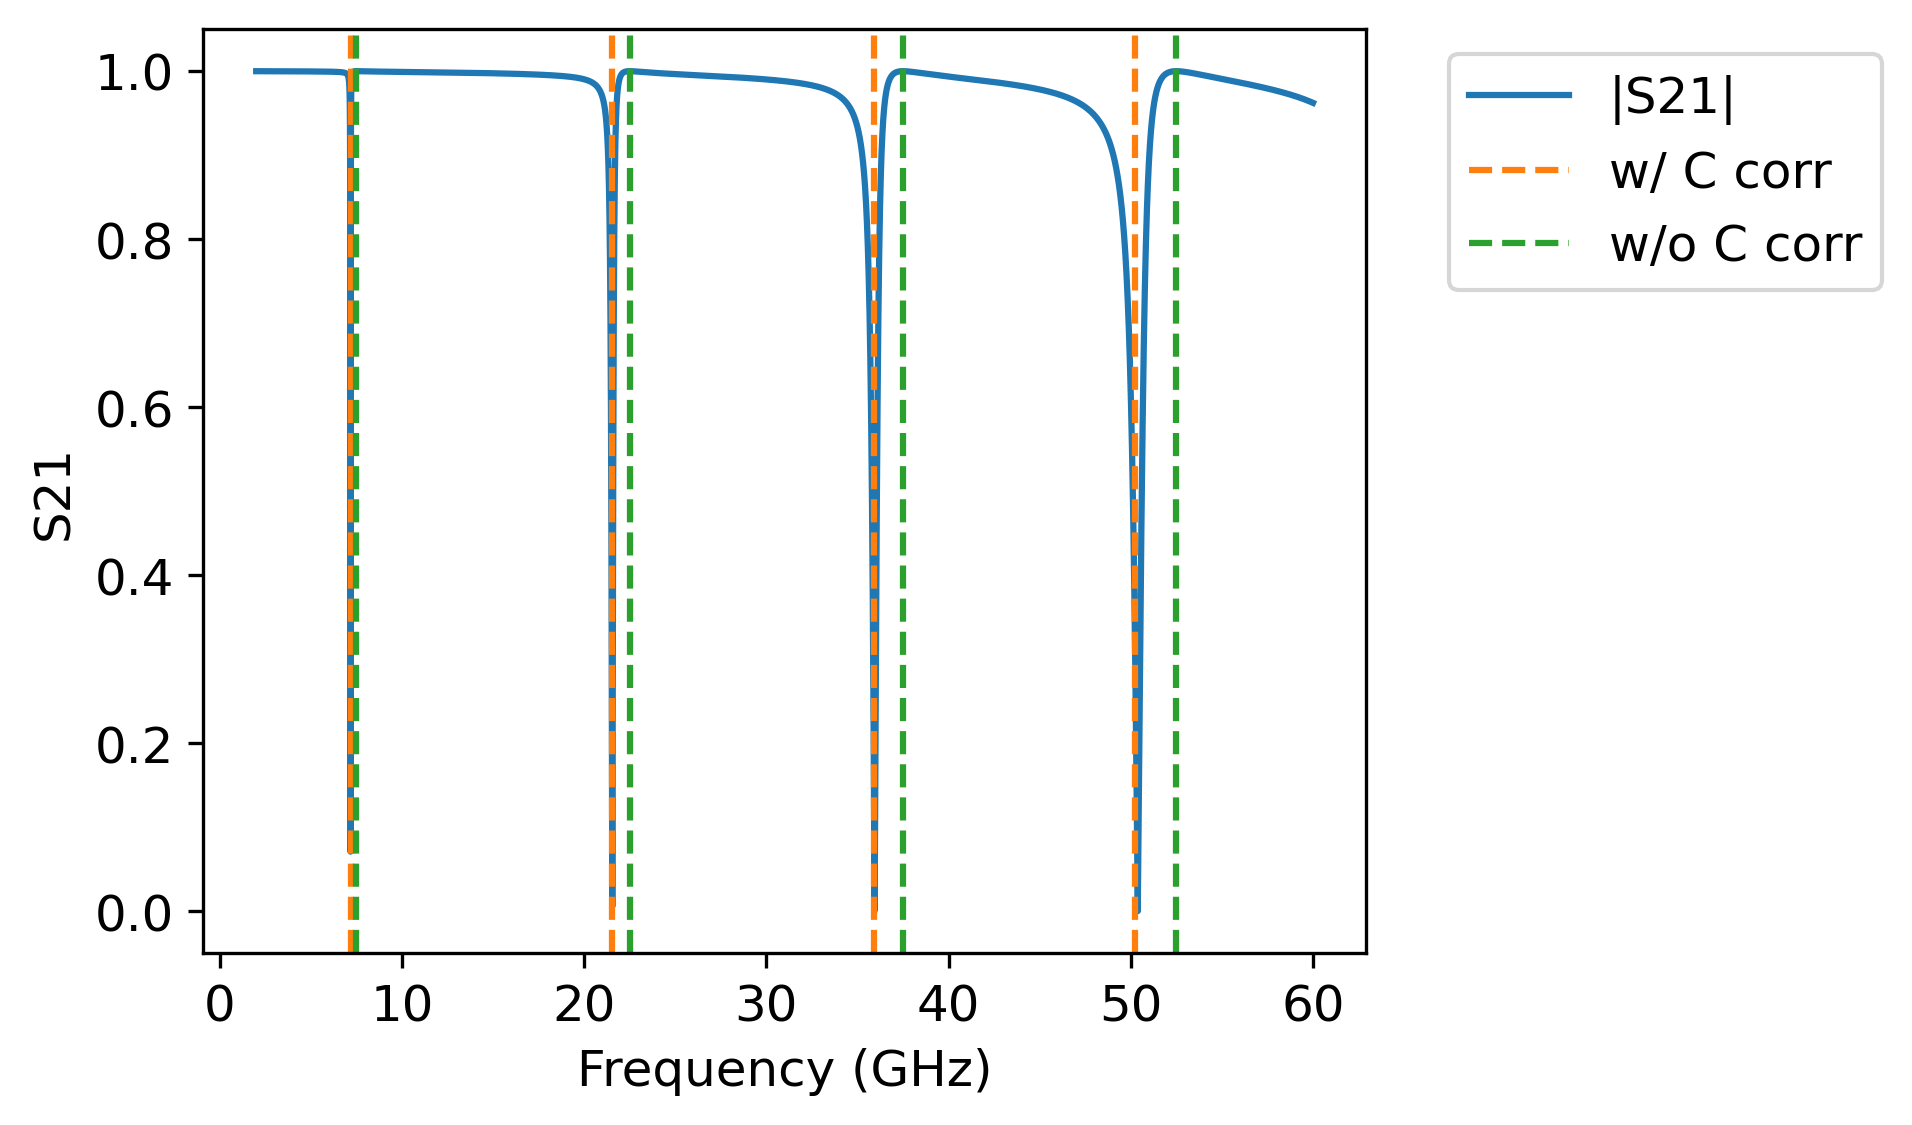

In [80]:
w_arr_2a = 2*pi* np.linspace(2, 60, 20_000) * GHz # frequency array in rad/s

plot_s21(
    w_arr_2a,
    [(np.abs(s21_1d), '|S21|', '-')],
    f_n_with_cap_correction_list,
    f_n_without_cap_correction_list,
    label_1='w/ C corr',
    label_2='w/o C corr'
)

## 2b: Construct lumped LC and half-wave resonators

Construct a parallel LC filter and a half-wave resonator with the same fundamental mode as the quarter-wave resonator.

### Lumped LC resonator

To approximate the fundamental mode of the quarter-wave resonance with a equivalent lumped LC circuit, we use the formulas given in Pozar. Find them in the slides.

Use the unloaded frequency ```w_0 = 2pi* 7.5 *GHz```. Calculate the inductance and capacitance of the equivalent LC circuit.

When constructing the ABCD matrix, use the same coupling capacitance as for the quarter-wave resonator: ```C = 30 *fF```.

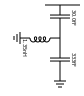

In [88]:

w0 = 2*pi* 7.5 *GHz
C = 30*fF

#-- TODO: Calculate the lumped resonator circuit paramaters and find the abcd matrix  ----
C_r = np.pi / 4 / w0 / z0
ind_r = 1 / w0 **2 / C_r 

abcd_2b_lumped = ABCDTJunction(
                    ABCDSeriesCapacitance(C)
                  * ABCDParallelInductance(ind_r)
                   * ABCDSeriesCapacitance(C_r) 
                  ) 

abcd_2b_lumped

Check your implementation.

In [89]:
test_abcd_2b_lumped(abcd_2b_lumped)

abcd_2b_lumped CORRECT.


Plot the S21 spectrum.

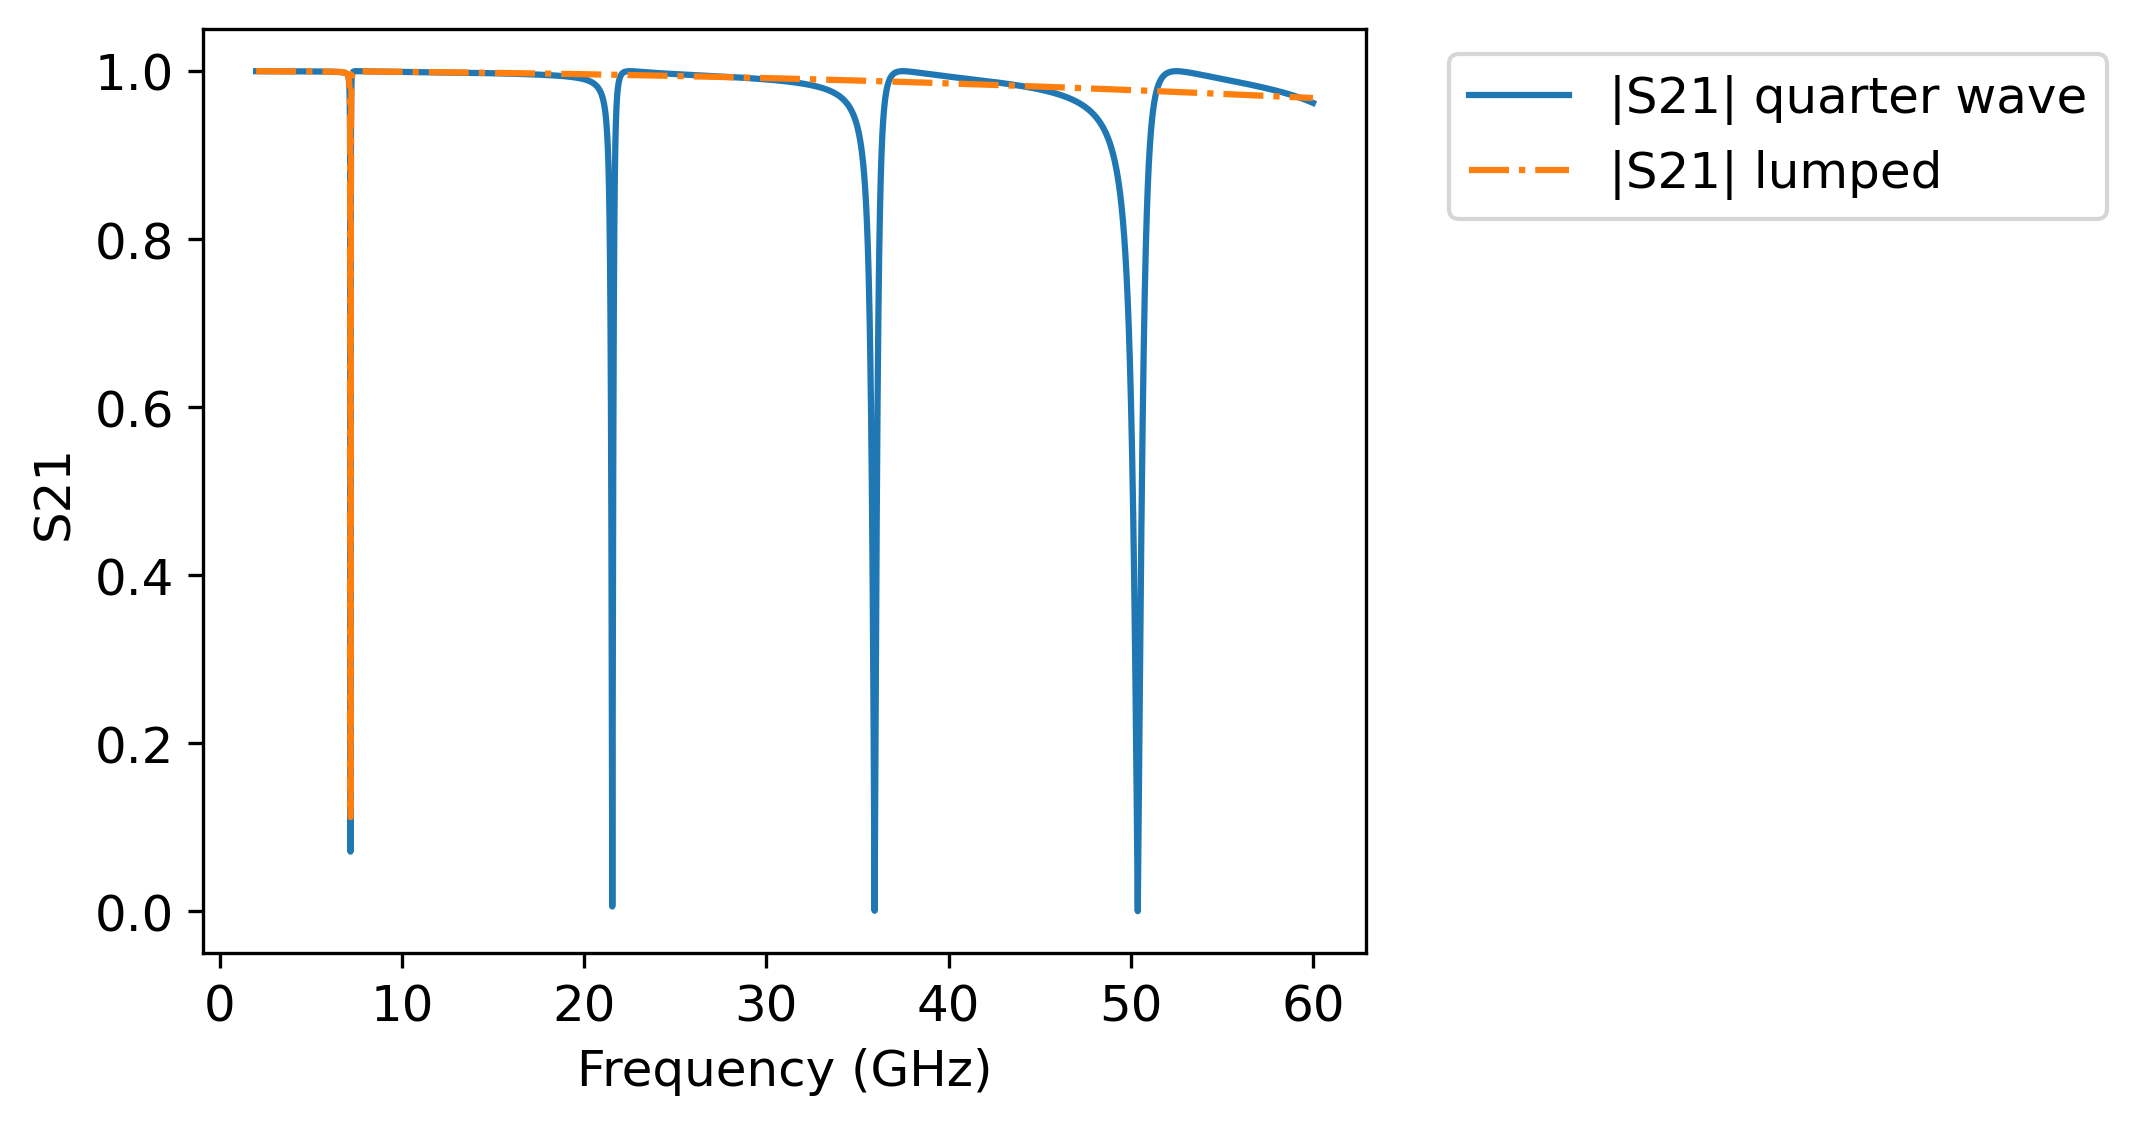

In [90]:
w_arr_2b = 2*pi* np.linspace(2, 60, 20_000) * GHz # frequency array in rad/s
s21_2b_quarter_wave = s21_1d.copy()
s21_2b_lumped = abcd_2b_lumped.sparams(w_arr_2b, z0)[2]

plot_s21(
    w_arr_2b,
    [(np.abs(s21_2b_quarter_wave), '|S21| quarter wave', '-'),
    (np.abs(s21_2b_lumped), '|S21| lumped', '-.')]
    )

### Half-wave resonator

Construct a half-wave resonator with the same fundamental mode as the quarter-wave resonator. Use the same coupling capacitance as for the quarter-wave resonator: ```C = 30 *fF``` for both ends of the half-wave resonator.

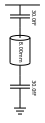

In [ ]:
C = 30*fF

#-- TODO: Calculate the lumped resonance and  -------------------------------------------------
l_half_wave = 2* 4000*um
abcd_2b_half_wave = ABCDTJunction(
    ABCDSeriesCapacitance(C)
    * ABCDTEMTransmissionLine(l_half_wave, z0, vp)
    * ABCDSeriesCapacitance(C)
)

abcd_2b_half_wave


Check your implementation.

In [93]:
test_abcd_2b_half_wave(abcd_2b_half_wave)

abcd_2b_lumped CORRECT.


Plot the S21 spectrum.

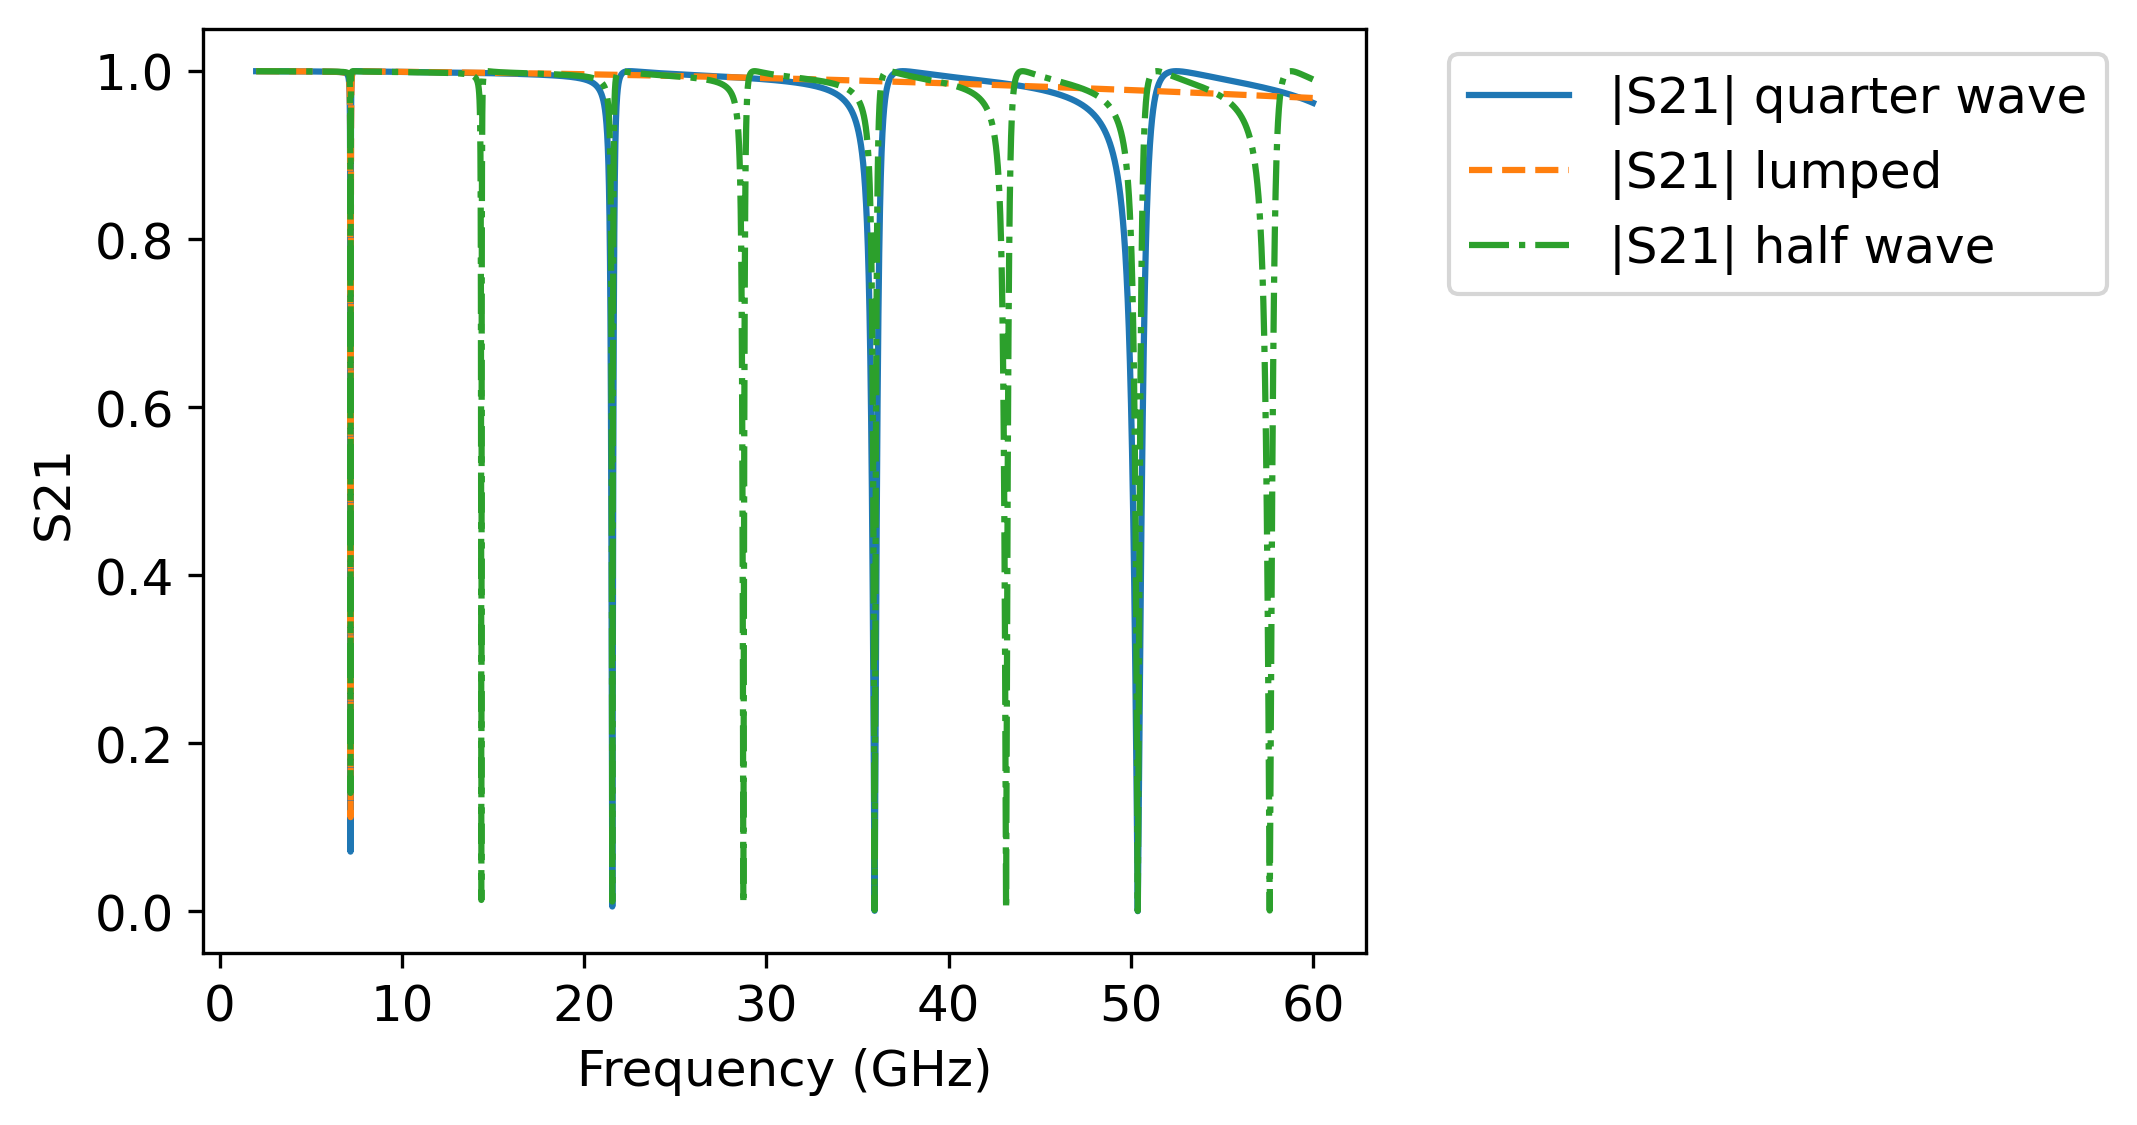

In [94]:
s21_2b_half_wave = abcd_2b_half_wave.sparams(w_arr_2b, z0)[2]

plot_s21(
    w_arr_2b,
    [(np.abs(s21_2b_quarter_wave), '|S21| quarter wave', '-'),
    (np.abs(s21_2b_lumped), '|S21| lumped', '--'),
    (np.abs(s21_2b_half_wave), '|S21| half wave', '-.')]
    )

## 2c: Fit to the quarter-wave resonance

Now, we want to zoom into the fundamental resonance and fit an anlaytic function to it. This will allow us to extract the linewidth kappa. 

First, define the Lorentzian function, used to fit to the data.

In [97]:
def get_s21_lorentzian(
        w_arr: np.ndarray, # array of frequencies in rad/s, shape (N,)
        wr: float, # resonance frequency in rad/s
        kappa: float, # coupling rate in rad/s
        phi: float, # phase in radians
) -> np.ndarray: # array of s21 values, one per frequency, shape (N,)
    

    #-- TODO: Complete the lorentzian function ------------------------------------------------
    s21_lorentzian = np.cos(phi) - np.exp(1j*phi) * kappa / (kappa + 2j* (wr - w_arr))

    return s21_lorentzian

Check your implementation

In [98]:
test_get_s21_2c(get_s21_lorentzian)

get_s21_lorentzian CORRECT.


Create s21 traces for different values of kappa and phi.

In [103]:
w_arr_2c = 2*pi* np.linspace(7.1, 7.26, 10_000) * GHz # frequency array in rad/s
wr = 2*pi* 7.18 *GHz # resonance frequency in rad/s

kappa_list = 2*pi* np.array([5, 15, 25]) * MHz # coupling rates in rad/s
phi_list = np.array([-pi/4, 0, pi/4]) # phase in radians

s21_kappa_list = [] # list of s21 values for different kappa
s21_phi_list = [] # list of s21 values for different phi

#-- TODO: calculate the s21 spectrum for different kappa and phi values --------------------------------

phi = 0 # Use phi = 0 for this list.
for kappa in kappa_list:
   s21_kappa = get_s21_lorentzian(w_arr_2c, wr, kappa, phi)
   s21_kappa_list.append(s21_kappa)

kappa = 2*pi*5*MHz # Use kappa = 2*pi* 5 *MHz for this list.
for phi in phi_list:
   s21_phi = get_s21_lorentzian(w_arr_2c, wr, kappa, phi)
   s21_phi_list.append(s21_phi)



Check your implementation

In [104]:
test_s21_kappa_phi_list_2c(
    s21_kappa_list,
    s21_phi_list
)

s21_kappa_list CORRECT.
s21_phi_list CORRECT.


Plot the S21 spectrum.

We translate the S21 spectra for the phi_list vertically for clarity.

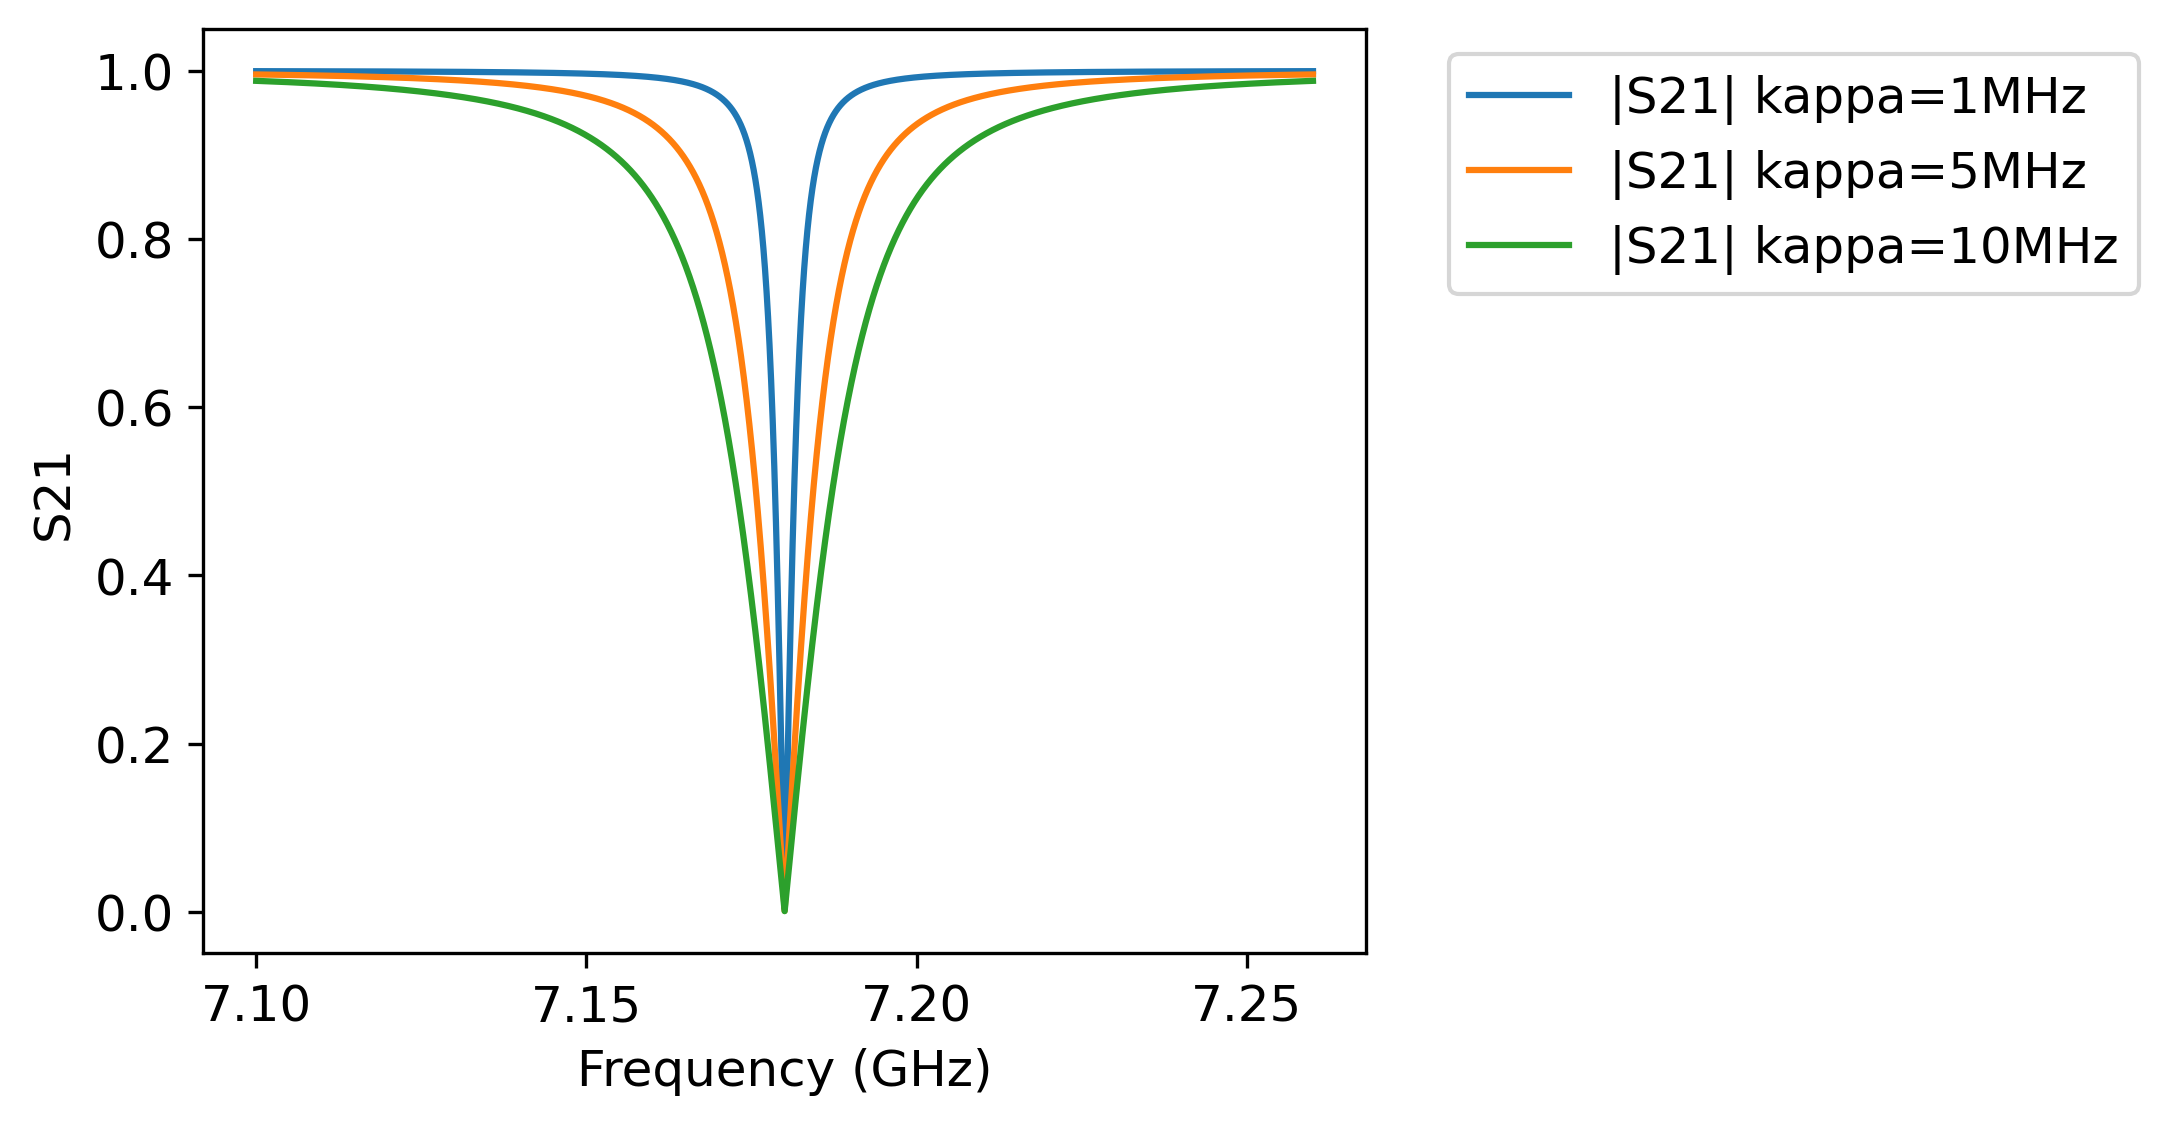

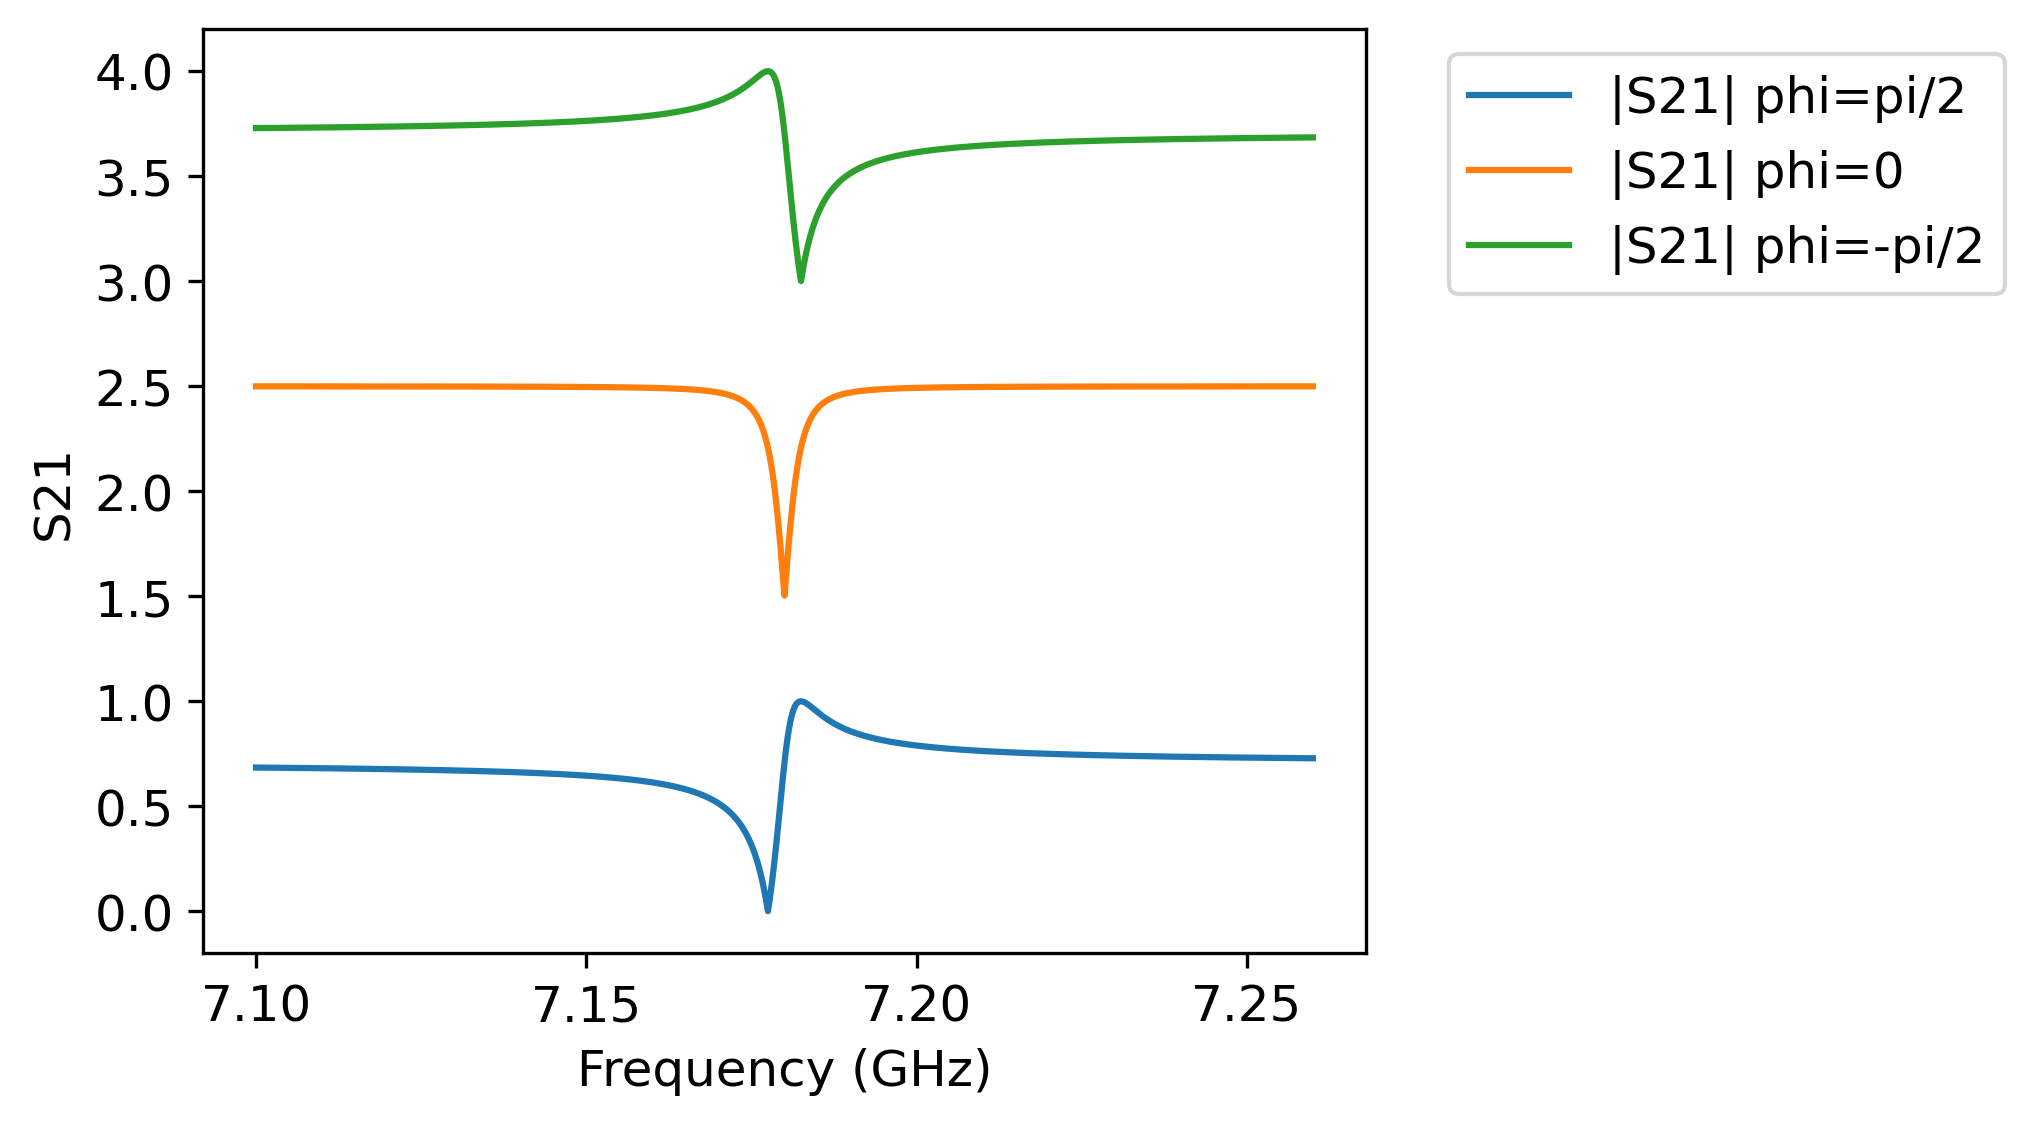

In [166]:
plot_s21(
    w_arr_2c,
    [(np.abs(s21_kappa_list[0]), '|S21| kappa=1MHz', '-'),
    (np.abs(s21_kappa_list[1]), '|S21| kappa=5MHz', '-'),
    (np.abs(s21_kappa_list[2]), '|S21| kappa=10MHz', '-')]
    )

plot_s21(
    w_arr_2c,
    [(np.abs(s21_phi_list[2]), '|S21| phi=pi/2', '-'),
    (np.abs(s21_phi_list[1])+1.5, '|S21| phi=0', '-'),
    (np.abs(s21_phi_list[0])+3, '|S21| phi=-pi/2', '-')]
    )

We recalculate the quarter-wave resonance and zoom in close to the resonance.

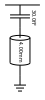

In [106]:
#-- Recalculate quarter wave resonator --------------------------------------------------
C = 30*fF
l = 4000*um

abcd_2c_quarter_wave = ABCDTJunction(
    ABCDSeriesCapacitance(C)
    * ABCDTEMTransmissionLine(l, z0, vp))
abcd_2c_quarter_wave

Plot the S21 transmission.

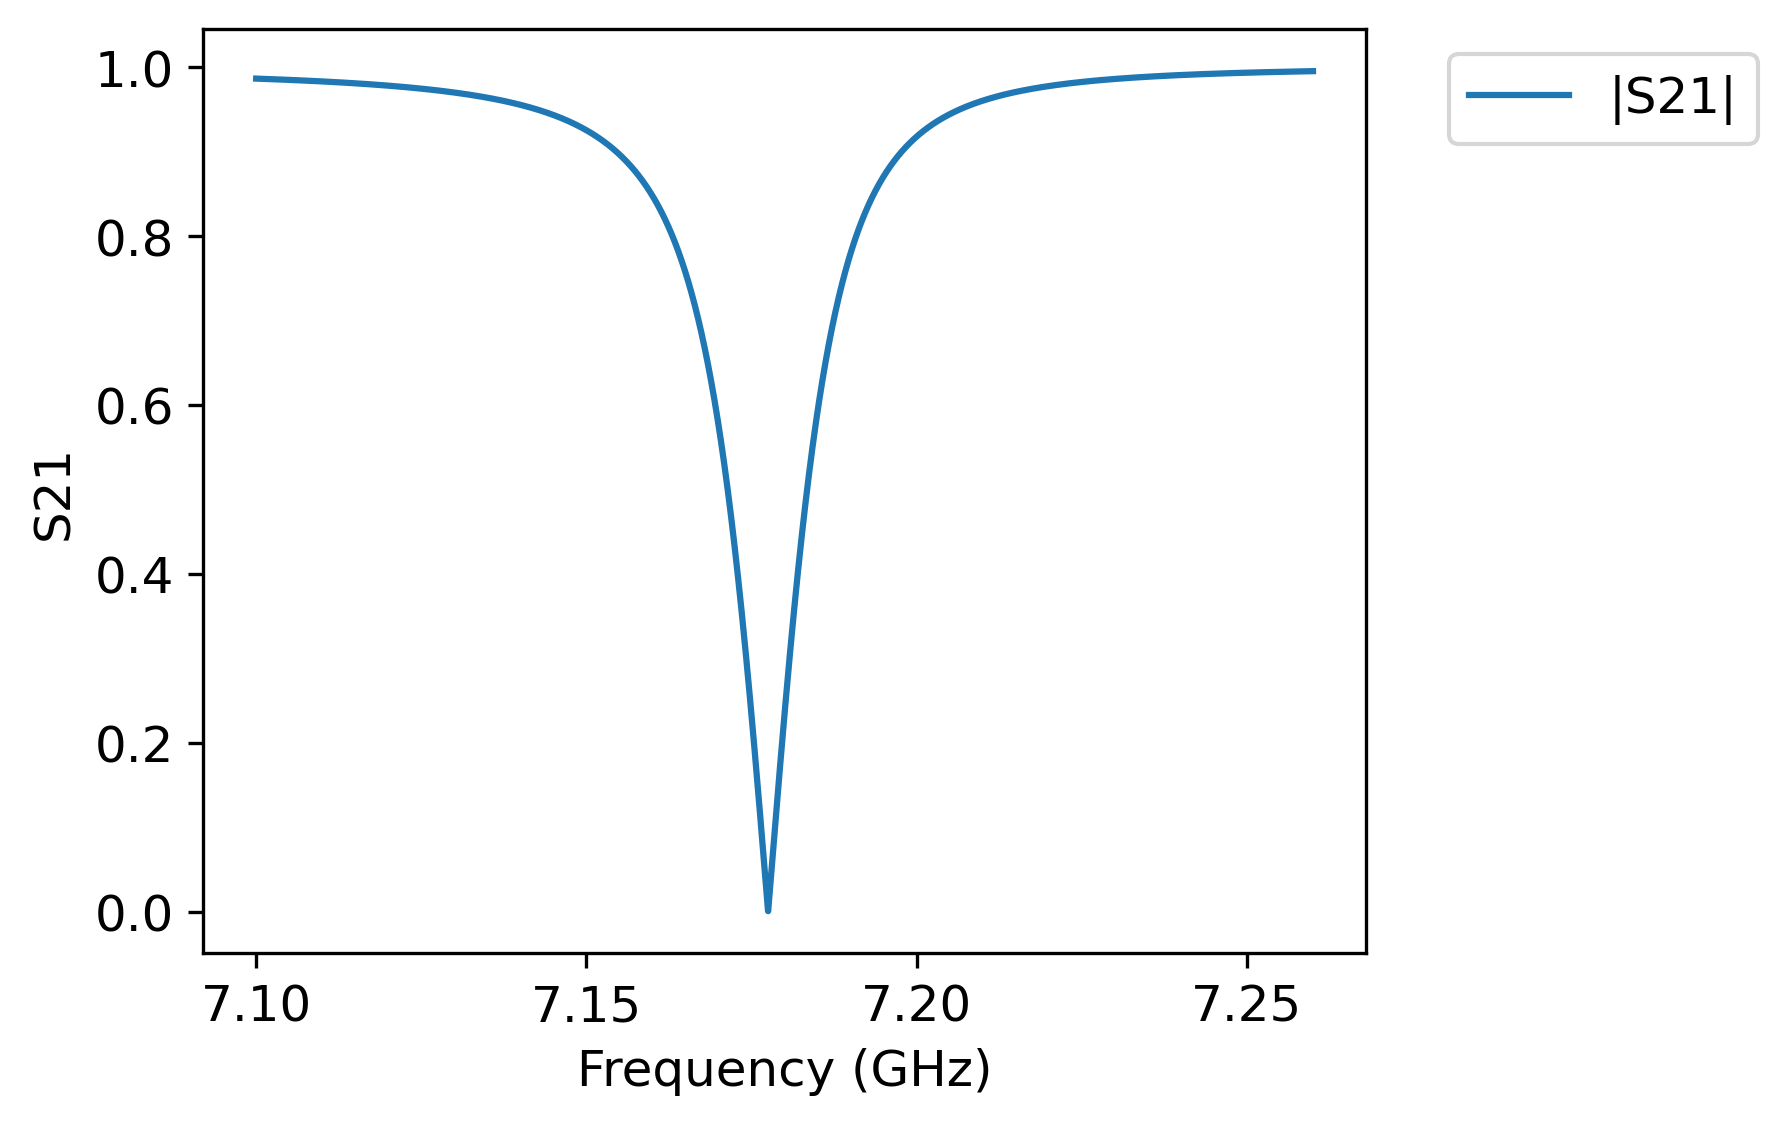

In [107]:
s21_2c = abcd_2c_quarter_wave.sparams(w_arr_2c, z0)[2]
plot_s21(
    w_arr_2c,
    [(np.abs(s21_2c), '|S21|', '-')]
)

Then, we fit the data using a function that uses a Lorentzian lineshape as defined above. Play close attention as to how we fit and extract the fitted parameters. You will need this later.

In [108]:
fit_results_dict_2c, s21_fit_trace_2c = fit_resonance(w_arr_2c, s21_2c)

# wr and kr are in rad/s
wr = fit_results_dict_2c['wr'] /2/pi/GHz # in GHz
kappa = fit_results_dict_2c['kr'] /2/pi/MHz # in MHz

print(f'wr = {wr:.2f} GHz')
print(f'kappa = {kappa:.2f} MHz')

wr = 7.18 GHz
kappa = 20.80 MHz


/opt/homebrew/Caskroom/miniconda/base/envs/abcd_workshop/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Plot the S21 spectrum with the fit.

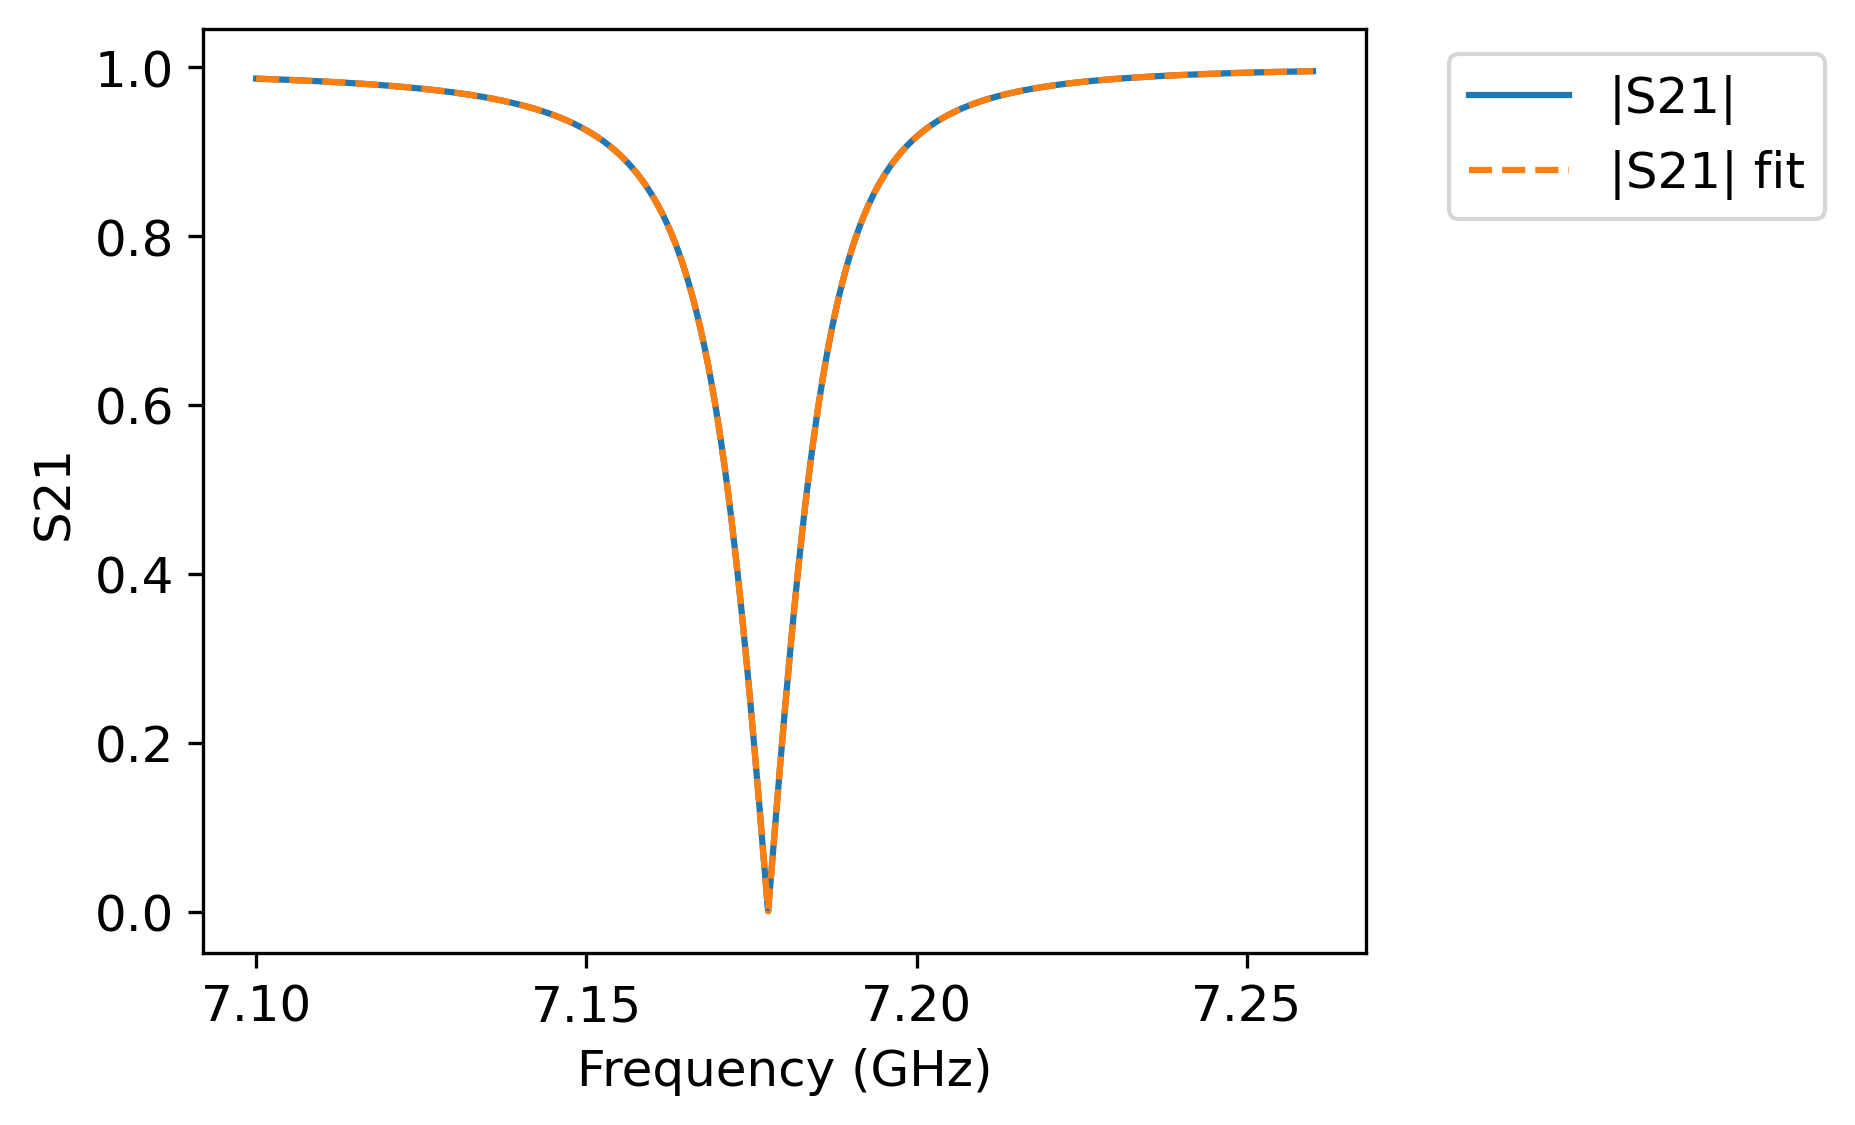

In [109]:
plot_s21(
    w_arr_2c,
    [(np.abs(s21_2c), '|S21|', '-'),
    (np.abs(s21_fit_trace_2c), '|S21| fit', '--')]
)

## 2d: Extract kappa on semi-infinite waveguide

We construct a semi-infinite waveguide with a quarter-wave resonator. The circuit is shown below.

<img src="images/abcd_2d.png" alt="ABCD Circuit" width="400">


First, implement this circuit for the values shown in the image and 

```python
lf1 = 2000*um
lf2 = 10000*um
```

Plot the S21 spectrum, fit the data and extract kappa.

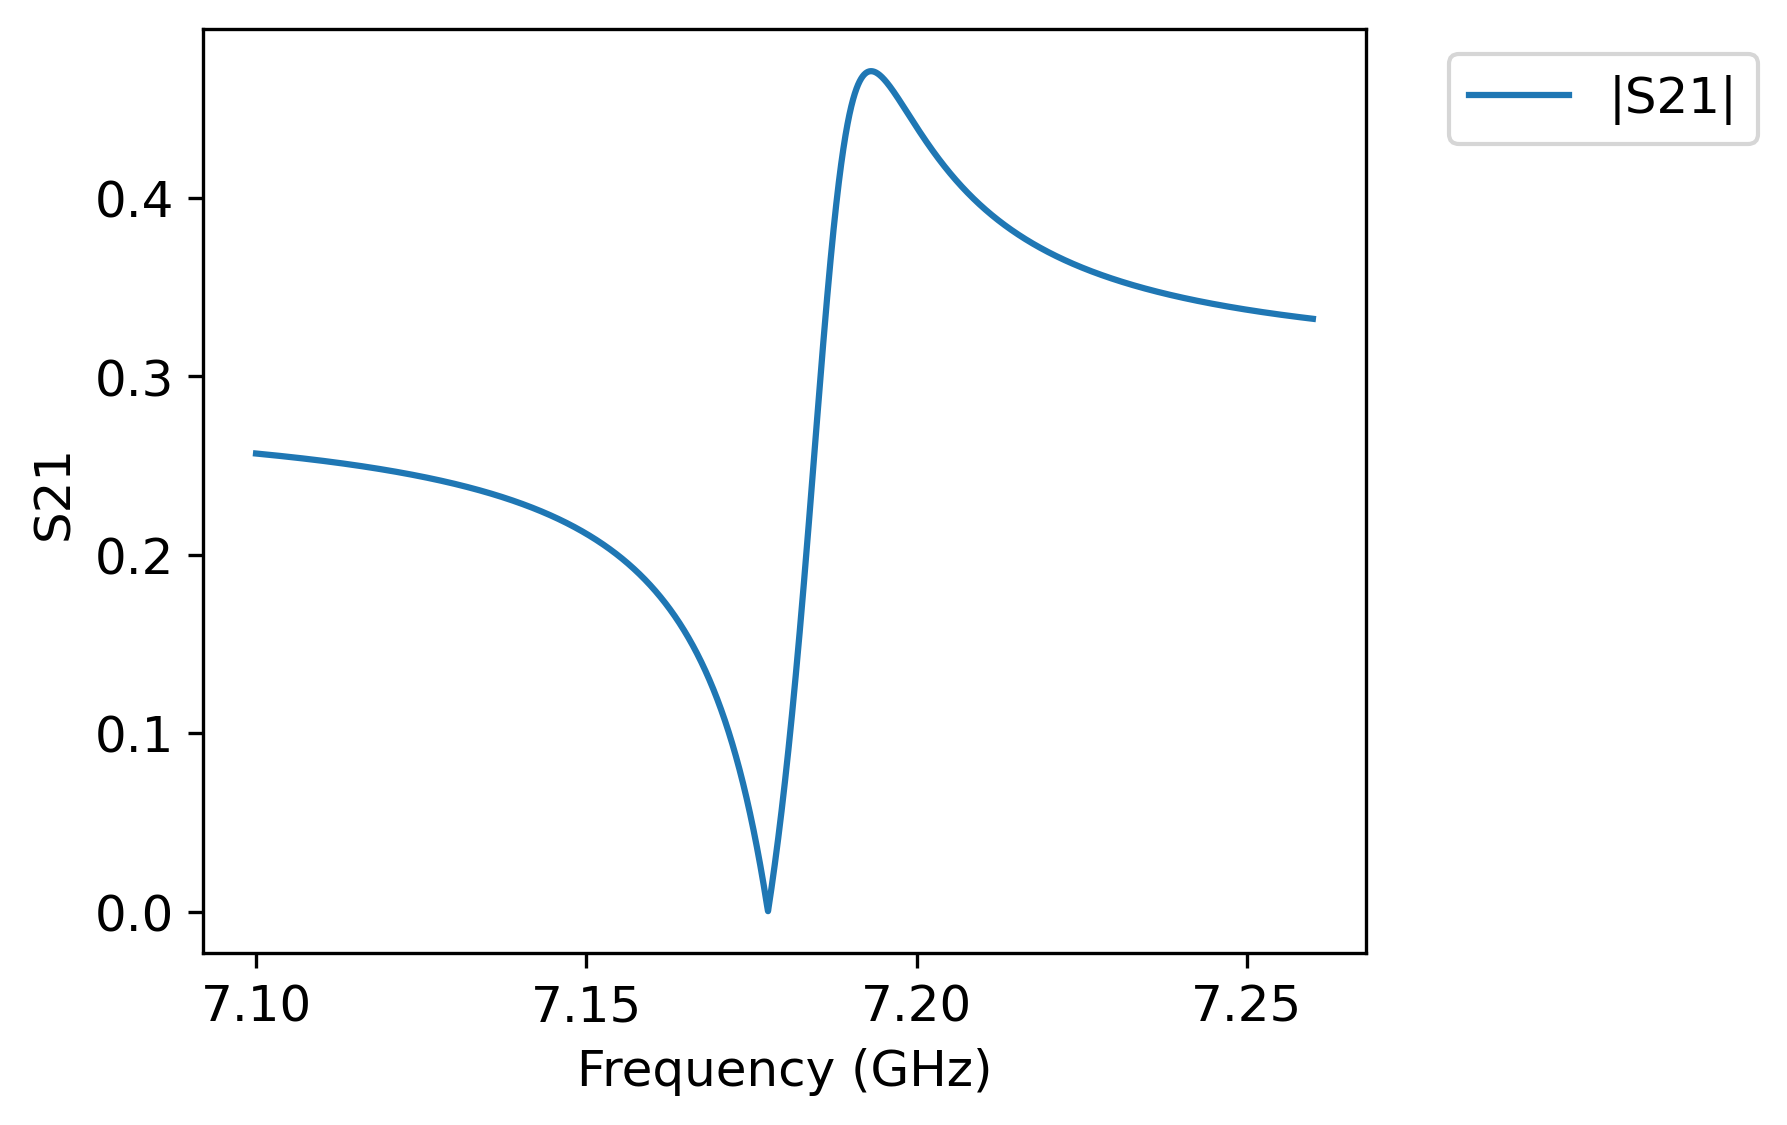

wr = 7.19 GHz
kappa = 15.19 MHz


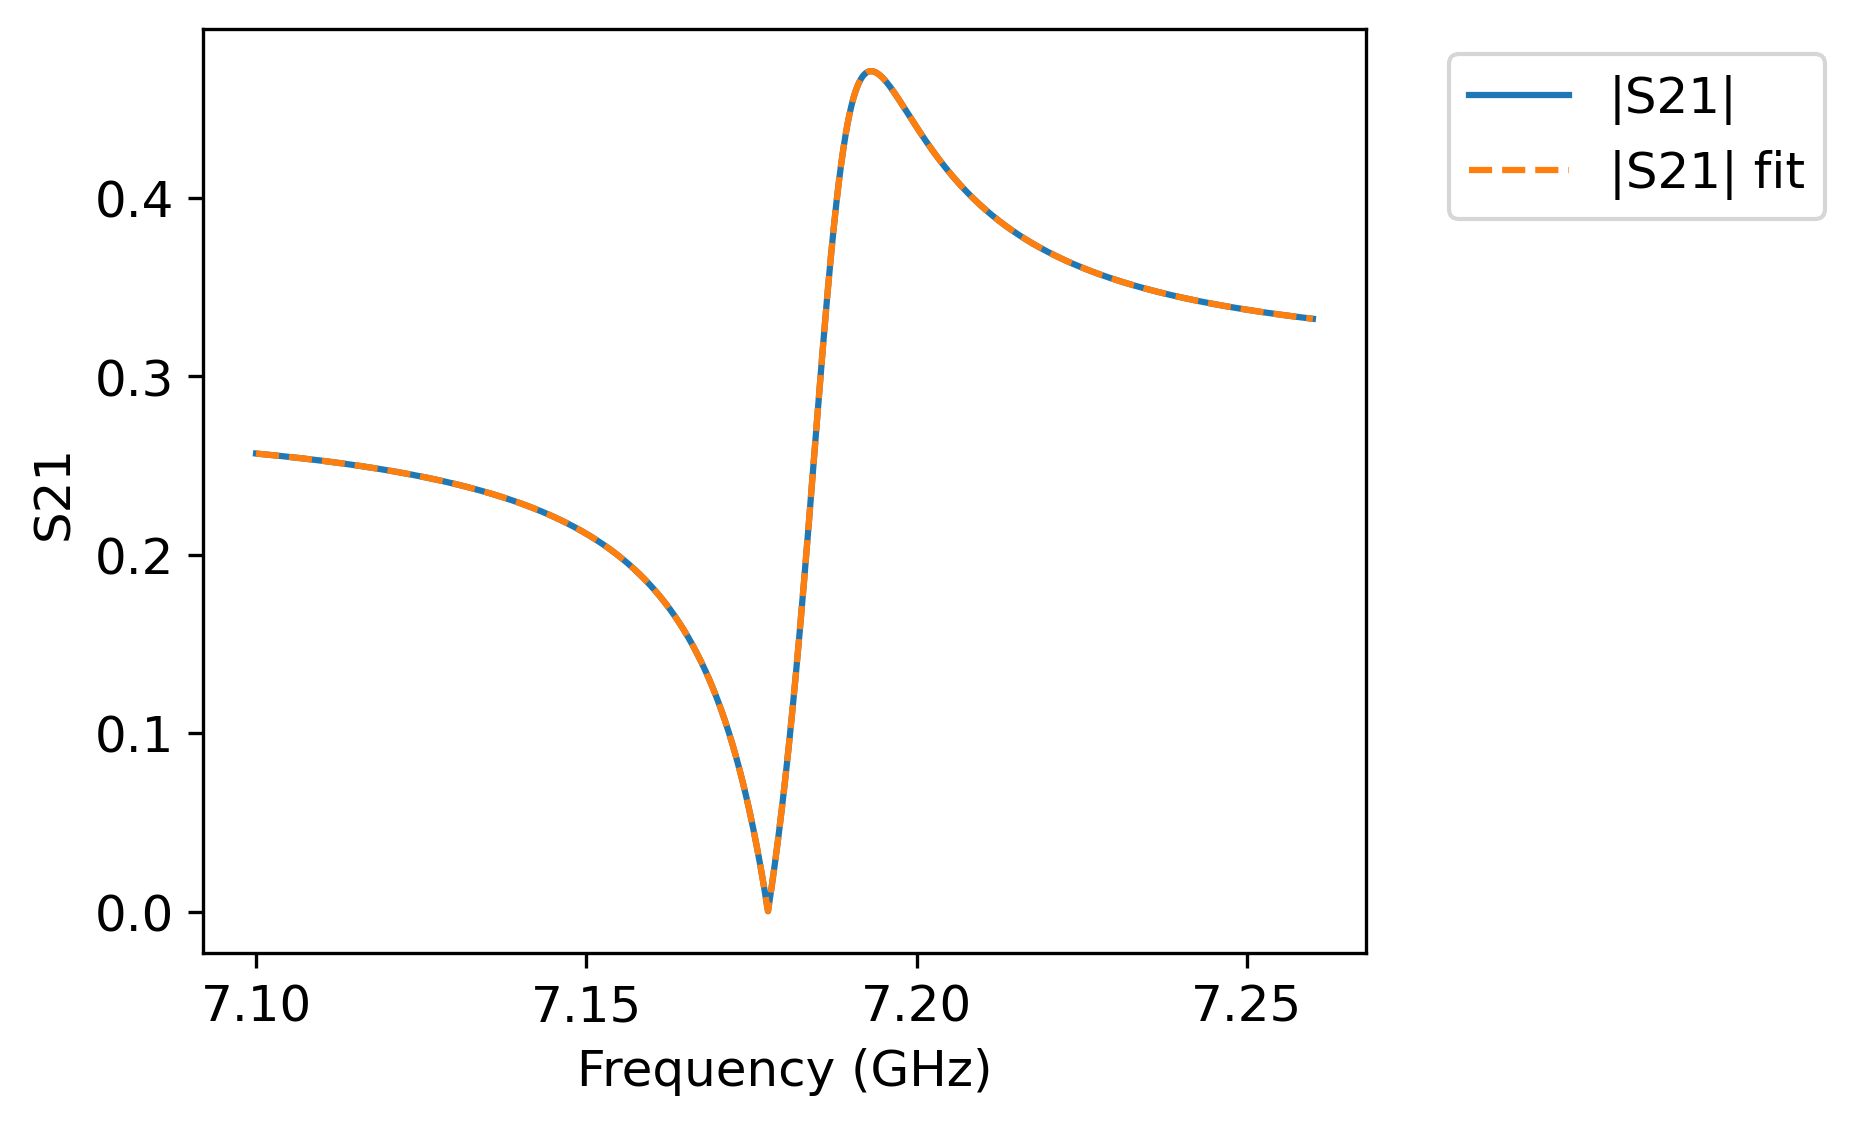

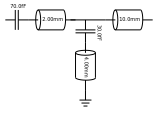

In [185]:
#-- TODO: Calculate the s21 spectrum, fit it and extract kappa -------------------------------------------------
C_1 = 70*fF
lf1 = 2000*um
lf2 = 10000*um
C_c =30*fF
l_half_wave = 4000*um
w_arr_2d = 2*pi* np.linspace(7.1, 7.26, 10_000) * GHz # frequency array in rad/s

abcd_semi_infinite_2d = (
                            ABCDSeriesCapacitance(C_1)* 
                          ABCDTEMTransmissionLine(lf1,z0,vp)
                         * ABCDTJunction(ABCDSeriesCapacitance(C_c)
                                         * ABCDTEMTransmissionLine(l_half_wave,z0,vp)) 
                        *  ABCDTEMTransmissionLine(lf2,z0,vp))

s21_2d = abcd_semi_infinite_2d.sparams(w_arr_2d, z0)[2]
plot_s21(
    w_arr_2d,
    [(np.abs(s21_2d), '|S21|', '-')]
)

fit_results_dict_2d, s21_fit_trace_2d = fit_resonance(w_arr_2d, s21_2d)
# wr and kr are in rad/s
wr = fit_results_dict_2d['wr'] /2/pi/GHz # in GHz
kappa = fit_results_dict_2d['kr'] /2/pi/MHz # in MHz

print(f'wr = {wr:.2f} GHz')
print(f'kappa = {kappa:.2f} MHz')

plot_s21(
    w_arr_2d,
    [(np.abs(s21_2d), '|S21|', '-'),
    (np.abs(s21_fit_trace_2d), '|S21| fit', '--')]
)

# Store your linewidth in kappa_2d. It must be in MHz.
kappa_2d = kappa


abcd_semi_infinite_2d

Check your implementation.

In [124]:
test_kappa_2d(kappa_2d) # kappa_2d must be in MHz

kappa_2d INCORRECT.


## 2e: Sweep coupling position along semi-infinite waveguide

Now, we sweep the coupling position of the quarter wave resonator, while extracting its linewidth. This means we keep 

```python
lf1 + lf2 = 12000*um
```

constant, while varying the coupling position ```lf1``` from 0 to 12000 um.

<img src="images/abcd_2d.png" alt="ABCD Circuit" width="400">


In [201]:
lf1_arr = np.linspace(0, 4000, 200)*um # array of lf1 values in um
kappa_list_2e = [] # list of kappa values for different lf1 values

#-- TODO: Calculate the s21 spectrum, fit it and extract kappa for different lf1 values ------------------------------


def get_abcd_semi_infitine(
        Cin: float, # input capactiance
        lf1: float, # length of first feedline section
        lf2: float, # length of second feedline section
        Cr: float, # resonator coupling capacitance
        z0: float, # characteristic impedance
        vp: float # phase velocity
) -> ABCDMatrix: # ABCD matrix of the semi-infinite transmission line
    abcd_semi_infinite = (
                            ABCDSeriesCapacitance(Cin) *
                          ABCDTEMTransmissionLine(lf1,z0,vp)
                         * ABCDTJunction(ABCDSeriesCapacitance(Cr)
                                         * ABCDTEMTransmissionLine(l_half_wave,z0,vp)) 
                        *  ABCDTEMTransmissionLine(lf2,z0,vp))
    return abcd_semi_infinite



for lf1 in lf1_arr:
    params = {
        'Cin': 70*fF,
        'lf1': lf1,
        'lf2': 4000*um - lf1,
        'Cr':30*fF,
        'z0': z0,
        'vp': vp
    }
    w_arr_2e = 2*pi* np.linspace(5, 7.26, 20_000) * GHz # frequency array in rad/s
    abcd_semi_infinite = get_abcd_semi_infitine(**params)
    s21_2e = abcd_semi_infinite.sparams(w_arr_2e, z0)[2]
    fit_results_dict_2e, s21_fit_trace_2e = fit_resonance(w_arr_2e, s21_2e)
    kappa = fit_results_dict_2e['kr'] /2/pi/MHz # in MHz
    kappa_list_2e.append(kappa)






Check your implementation.

In [200]:
test_kappa_list_2e(kappa_list_2e) # kappa_list_2e must be in MHz

ValueError: operands could not be broadcast together with shapes (100,) (200,) 

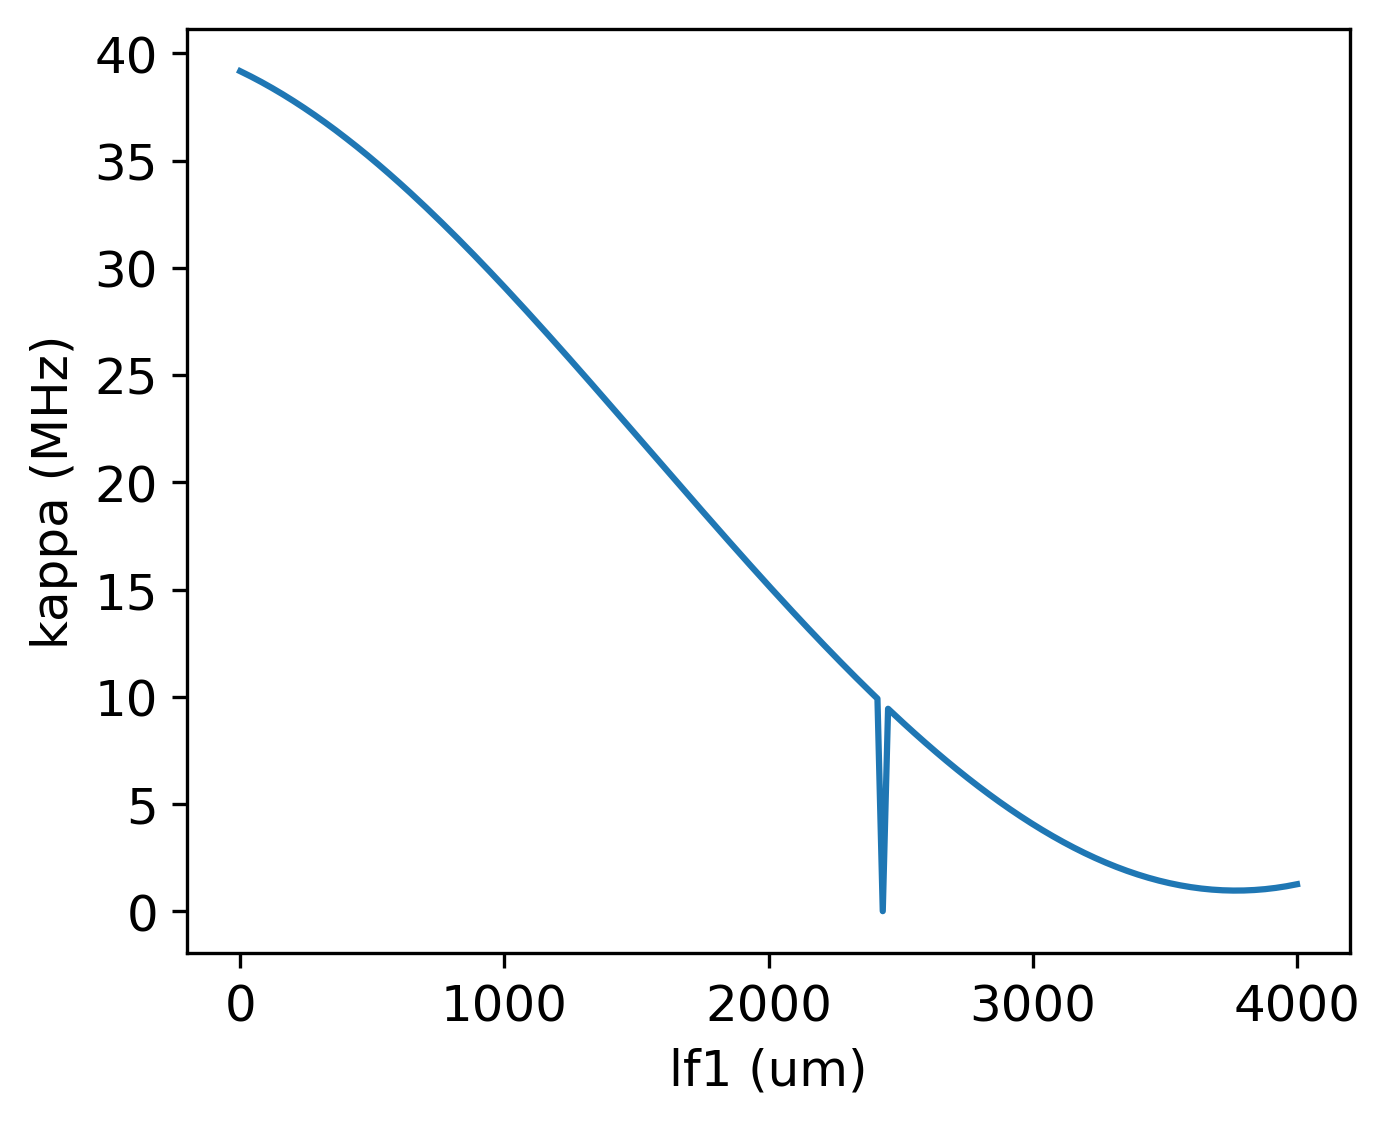

In [202]:
plt.plot(lf1_arr/um, kappa_list_2e)
plt.xlabel('lf1 (um)')
plt.ylabel('kappa (MHz)')
plt.show()

### Question
Calculate at what distances we have nodes and antinodes. Can you explain this?

#TODO: Answer here

## 2f (optional): Study circuit crosstalk in multiplexed resonator systems

Study how resonators parastically affect each other. Construct the system below, where we have two quarter-wave resonators, coupled to a common semi-inifinite waveguide at different positions.


Sweep the coupling position of the 4mm resonator, while keeping the 4.6mm resonator fixed. Our feedline has a total length of 12mm, and the 4.6mm resonator remains at a fixed distance from the input capacitance of 8mm.

As you sweep the 4mm resonator, fit to the resonance of the 4.6mm resonator, extracting a list of kappa values. Plot these values.

Once you have completed this task, discuss your results with an instructor.

<img src="images/abcd_pert_2f.png" alt="ABCD Circuit" width="400">


# Exercise 3: Implementing Reed, et al., 2010

Let's try to rebuild a microwave circuit from a paper. Here, we'll work try to simulate the circuit used for the first demonstration of a Purcell filter. The paper is called: "Fast Reset and Suppressing Spontaneous Emission of a Superconducting Qubit" by Reed, et al., 2010, APL. Link: https://arxiv.org/abs/1003.0142. 

The basic idea is to add a stopband resonator to the readout resonator, which suppresses transmission at the qubit frequency, but not at the readout frequency. This allows us to implement strong readout coupling, while keeping the qubit protected.

We will rebuild the stopband-resonator system from Fig. 1a and simulate the S21 spectrum. This should agree with Fig. 1c.

To do this, find the circuit parameters from the paper. Note that 

```python
Ctot = Cin + Cout.
```

Ignore the qubit, i.e., implement only the cavity and the twin stopband filters. Use a small capacitance 

```python
Copen = 0.1 fF
```
at the far ends of the stopband filters.


Remember that the cavity is loaded by the capacitances. Make sure to include this when caclulating the length of the cavity transmission line from its resonance frequency. In the case of a half-wave resonator, we have

```python
l_eff = l + vp*Z0 * (Cin + Cout).
```

For the stopband resontors, ignore any capacitive corrections. In this instance, they are negligible.

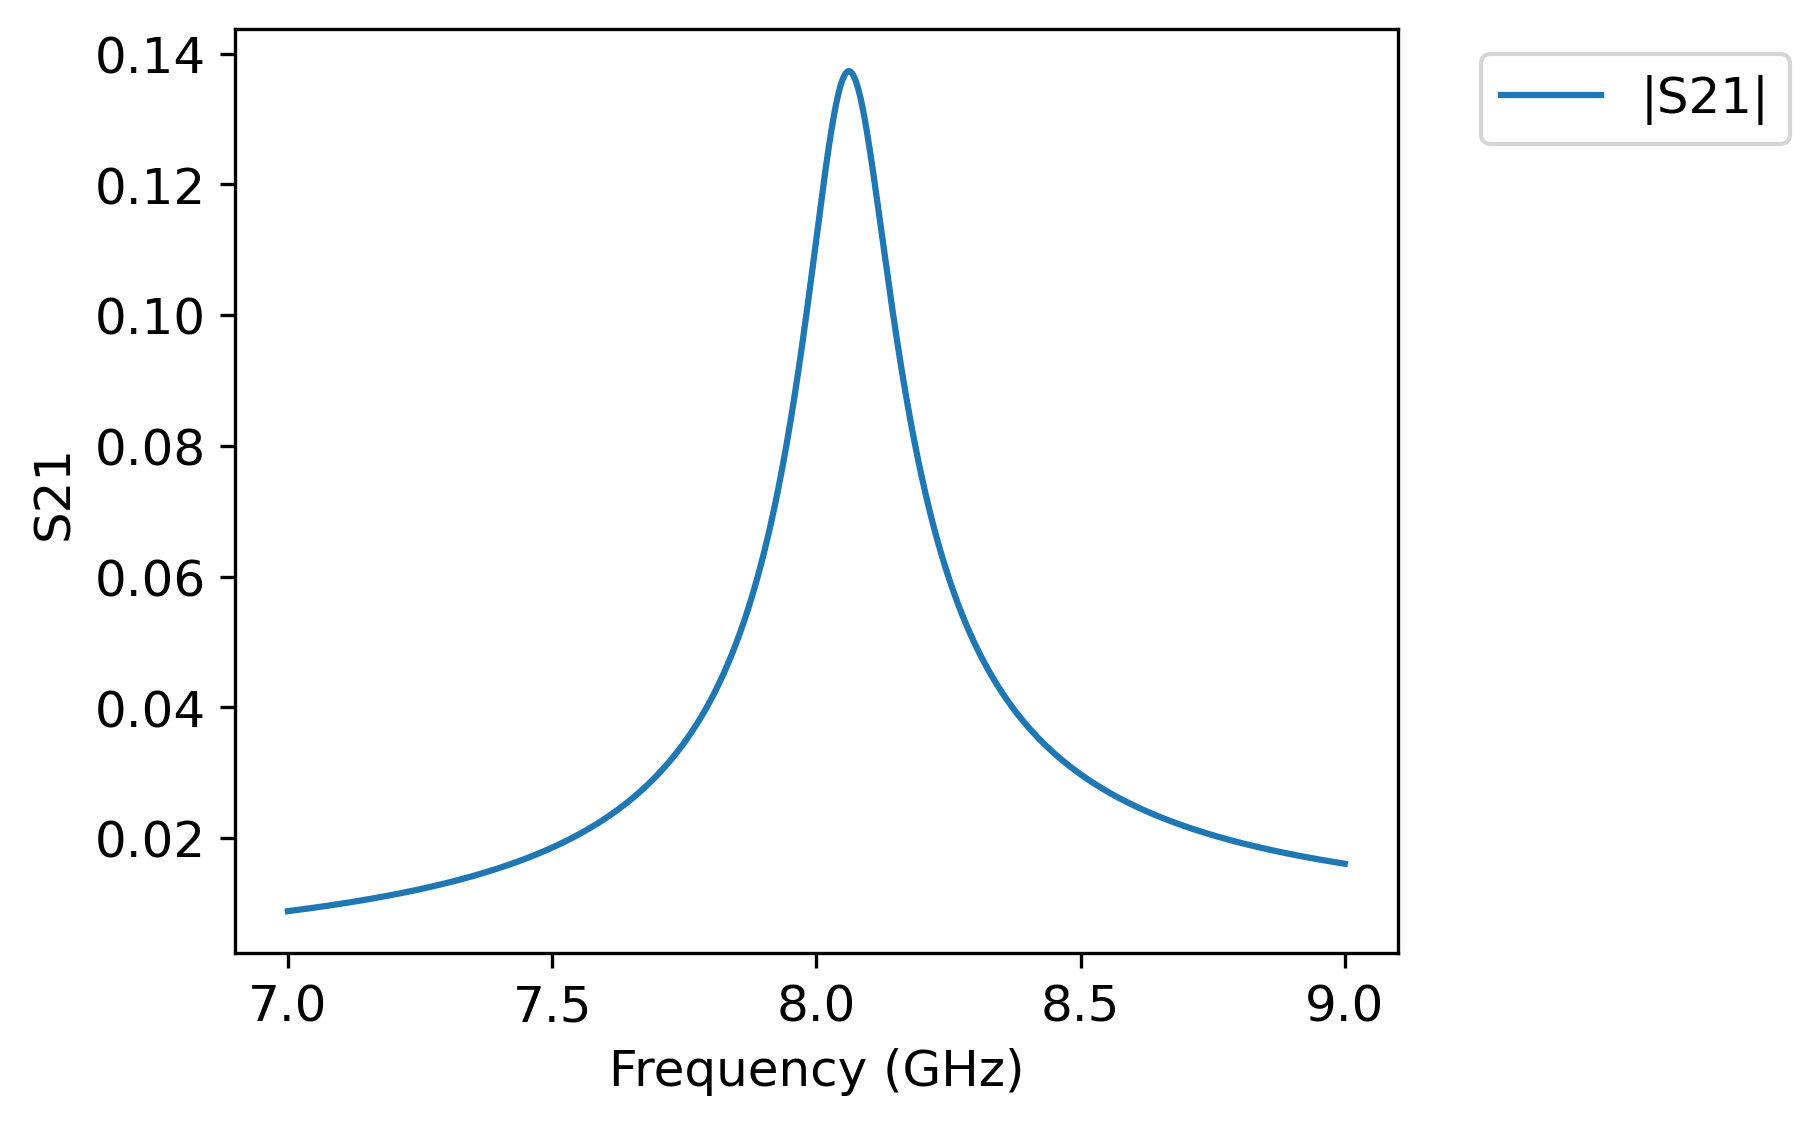

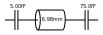

In [144]:
#-- TODO: Implement the circuit from the paper ------------------------------------------------
# ...
Ctot = 80*fF
Cout = Ctot / (1 + 1 / 15)
Cin = Ctot - Cout

fc= 8.04*GHz
lambda_half_wave = vp / fc

l_half_wave = lambda_half_wave / 2 - vp* z0 * Ctot


w_arr_half_wave_3 = 2 * pi * np.linspace(7, 9, 10_000) * GHz  # frequency array in rad/s

abcd_half_wave_3 = (
    ABCDSeriesCapacitance(Cin) *
    ABCDTEMTransmissionLine(l_half_wave, z0, vp) *
    ABCDSeriesCapacitance(Cout)
)

s21_half_wave_3 = abcd_half_wave_3.sparams(w_arr_half_wave_3, z0)[2]

abcd_half_wave_3

plot_s21(
    w_arr_half_wave_3,
    [(np.abs(s21_half_wave_3), '|S21|', '-')]
)
# abcd_total_3 = # store your result in this variable

abcd_half_wave_3

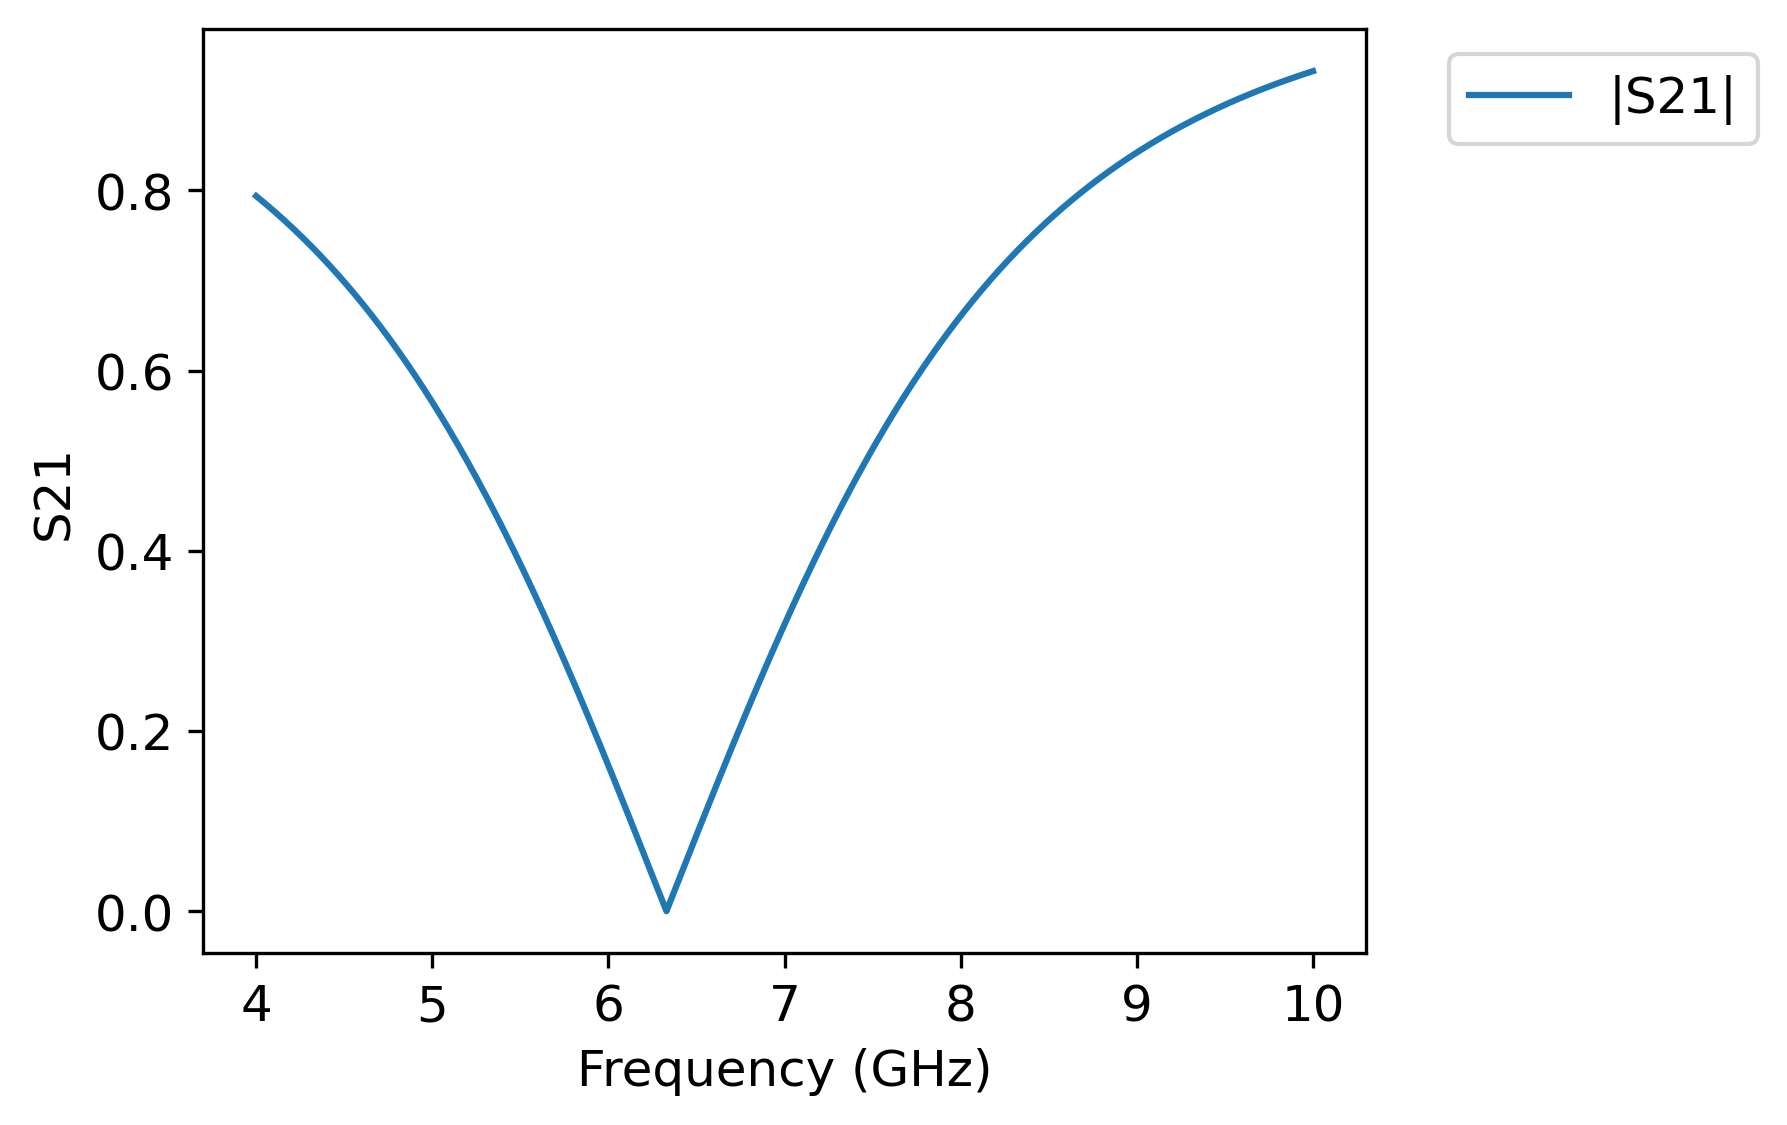

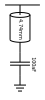

In [158]:
w_arr_stopband_3 = 2 * pi * np.linspace(4, 10, 10_000) * GHz  # frequency array in rad/s
# w_arr = 2 * pi * np.linspace(6.2, 6.5, 10_000) * GHz  # frequency array in rad/s

ff = 6.33 * GHz
lambda_stop_band = vp / ff
l_stop_band = lambda_stop_band / 4
c_open = 0.1 * fF

abcd_filter_3 = ABCDTJunction(
    ABCDTEMTransmissionLine(l_stop_band, z0, vp) *
    ABCDSeriesCapacitance(c_open)
)

s21_filter_3 = abcd_filter_3.sparams(w_arr_stopband_3, z0)[2]
plot_s21(
    w_arr_stopband_3,
    [(np.abs(s21_filter_3), '|S21|', '-')]
)

abcd_filter_3

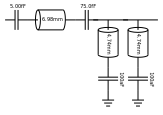

In [159]:
abcd_total_3 = (
    ABCDSeriesCapacitance(Cin) *
    ABCDTEMTransmissionLine(l_half_wave, z0, vp) *
    ABCDSeriesCapacitance(Cout) *
    ABCDTJunction(
        ABCDTEMTransmissionLine(l_stop_band, z0, vp) *
        ABCDSeriesCapacitance(c_open)
    ) *
    ABCDTJunction(
        ABCDTEMTransmissionLine(l_stop_band, z0, vp) *
        ABCDSeriesCapacitance(c_open)
    )
)

abcd_total_3


Plot s21 spectrum.

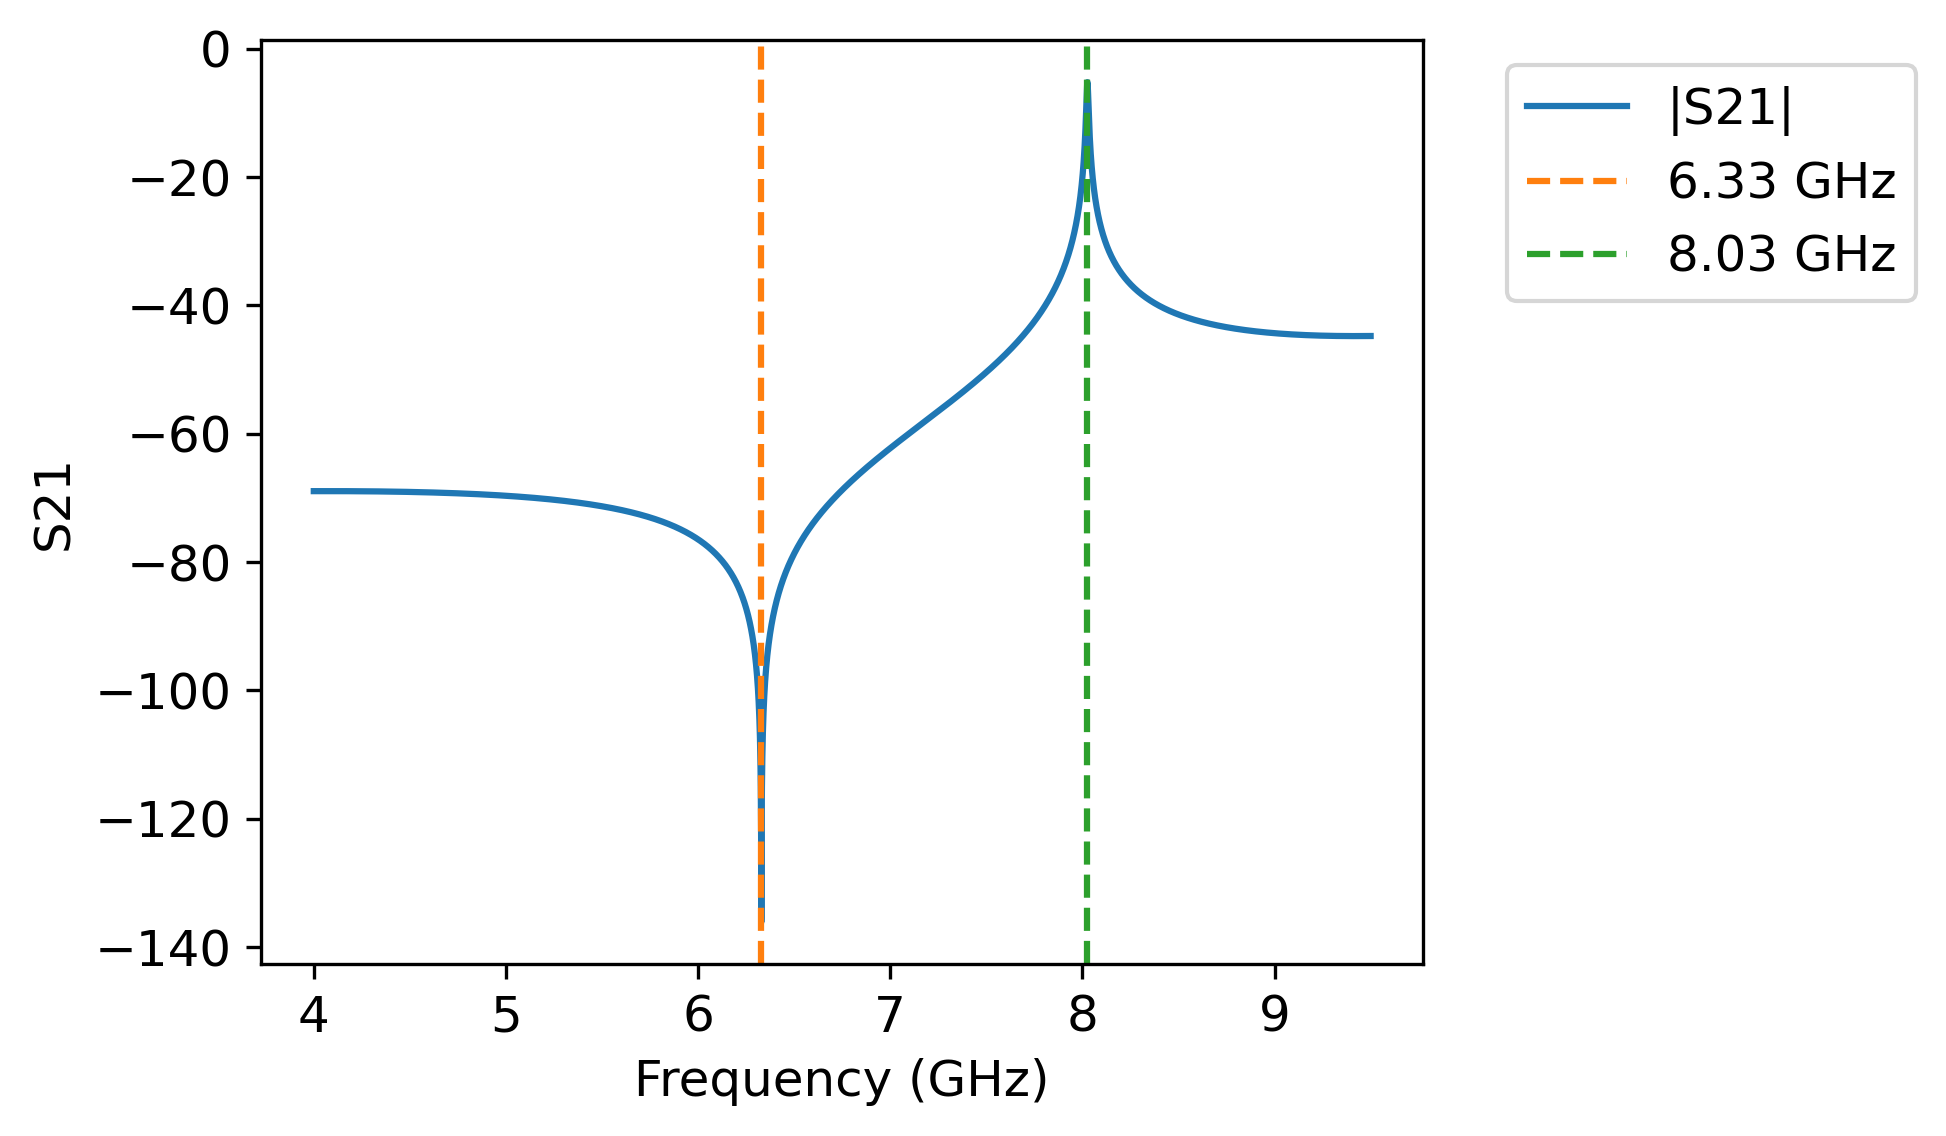

In [168]:

w_arr_3 = 2*pi* np.linspace(4, 9.5, 10_000) * GHz # frequency array in rad/s
s21_total_3 = abcd_total_3.sparams(w_arr_3, z0)[2]

min_s21_freq = w_arr_3[np.argmin(np.abs(s21_total_3))]
max_s21_freq = w_arr_3[np.argmax(np.abs(s21_total_3))]

plot_s21(
    w_arr_3,
    [(20*np.log10(np.abs(s21_total_3)), '|S21|', '-')],
    [min_s21_freq/2/pi/GHz],
    [max_s21_freq/2/pi/GHz],
    label_1=f'{min_s21_freq/2/pi/GHz:.2f} GHz',
    label_2=f'{max_s21_freq/2/pi/GHz:.2f} GHz'
)

Check your implementation.

In [161]:
test_paper_trace_3(s21_total_3)

paper_trace CORRECT.





#   #         ####            #    #   #  #####   ###    ###   #   #  #####  
#   #         #   #          # #   #   #  #      #      #   #  ## ##  #      
#   #         ####          #####  # # #  #####   ###   #   #  # # #  #####  
#   #         #  #          #   #  ## ##  #          #  #   #  #   #  #      
 ###          #   #         #   #  #   #  #####  ####    ###   #   #  #####  





 ###    ###   ####   #####  #   #            ##  ###           #   #   ###   #   #  
#      #   #  #   #  #      #   #           ##      #           # #   #   #  #   #  
 ###   #   #  #   #  #####  # # #          ##     ##             #    #   #  #   #  
    #  #  ##  #   #  #      ## ##           ##      #            #    #   #  #   #  
####    ## #  ####   #####  #   #            ##  ###             #     ###    ###   


# Reading list

If you're awesome and have managed to finish all exercises, you can read the following papers that rely involve the effects of transmission lines.

https://arxiv.org/abs/0807.4094 Goeppl, et al., 2008 (Characterizing CPW resonators) <br>
https://arxiv.org/abs/1401.0257 Sank, et al., 2014 (Introducing broadband Purcell filters) <br>
https://arxiv.org/abs/1801.07904 Heinsoo, et al., 2018 (Multiplexed readout, with individual Purcell filters) <br>
https://arxiv.org/abs/2202.06202 Sunada, et al., 2022 (Intrinsic Purcell filter through mode coupling) <br>
https://arxiv.org/abs/2403.01375 Yen, et al., 2024 (Directional readout) <br>
https://arxiv.org/abs/2409.04967v2 Spring, et al., 2024 (Intrinsic Purcell filter through multi-transmission line coupling) <br>
